# 0.0 IMPORTS

In [185]:
import math
import pandas as pd
import numpy as np
import inflection
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from IPython.core.display  import HTML
from IPython.display       import Image
from scipy                 import stats as ss

## 0.1. Helper Functions

In [89]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / ( min(kcorr-1,rcorr-1)))


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [90]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\anaconda\Lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['grid', 'cm']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Loading data

In [92]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

In [93]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
21060,991,1,2015-07-13,7741,642,1,1,0,1,a,a,1010.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0 PASSO 01 - DESCRICAO DOS DADOS

In [94]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [95]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [96]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map ( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [97]:
print( 'Number of Rows: {}'.format( df1.shape[0]) )
print( 'Number of Cols: {}'.format( df1.shape[1]) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [98]:
df1['date'] = pd.to_datetime( df1['date'] ) #transforma date que antes era object para datetime64[ns]
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [99]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [100]:
df1['competition_distance'].max()

75860.0

In [101]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year   
df1['competition_open_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
                             
#promo2_since_week  
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year 
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval  
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True) #preenchue com NA para nao usar isnan

df1['month_map'] = df1['date'].dt.month.map(month_map) #criacao do month_map extraindo o mes da data aplicando esse dicionario para fazer a traducao

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply ( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )

In [102]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [103]:
df1.sample(5).T

,358186,108327,864455,134690,403166
store,313,173,1,891,424
day_of_week,6,6,5,4,7
date,2014-08-23 00:00:00,2015-04-25 00:00:00,2013-05-17 00:00:00,2015-04-02 00:00:00,2014-07-06 00:00:00
sales,4299,6344,4856,10966,0
customers,463,773,597,1407,0
open,1,1,1,1,0
promo,0,0,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,1,0
store_type,d,a,c,a,d


## 1.6. Change Types

In [104]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [105]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

In [106]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [107]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] ) #variaveis numericas
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]']) #variaveis categoricas

In [108]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,promo2,is_promo
817516,1007,6,7899,980,1,0,0,4180.0,0,0
372869,1089,5,9688,1001,1,1,1,5220.0,0,0


In [109]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year,promo_interval,month_map
953543,0,d,c,2,2013,9,2011,"Mar,Jun,Sept,Dec",Fev
802999,0,c,c,5,2007,13,2010,"Jan,Apr,Jul,Oct",Jul


## 1.7.1. Numerical Attributes

In [110]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 

In [111]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


C:\Users\Admin\AppData\Local\Temp\ipykernel_4392\2697858400.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df1['competition_distance'])


<Axes: xlabel='competition_distance', ylabel='Density'>

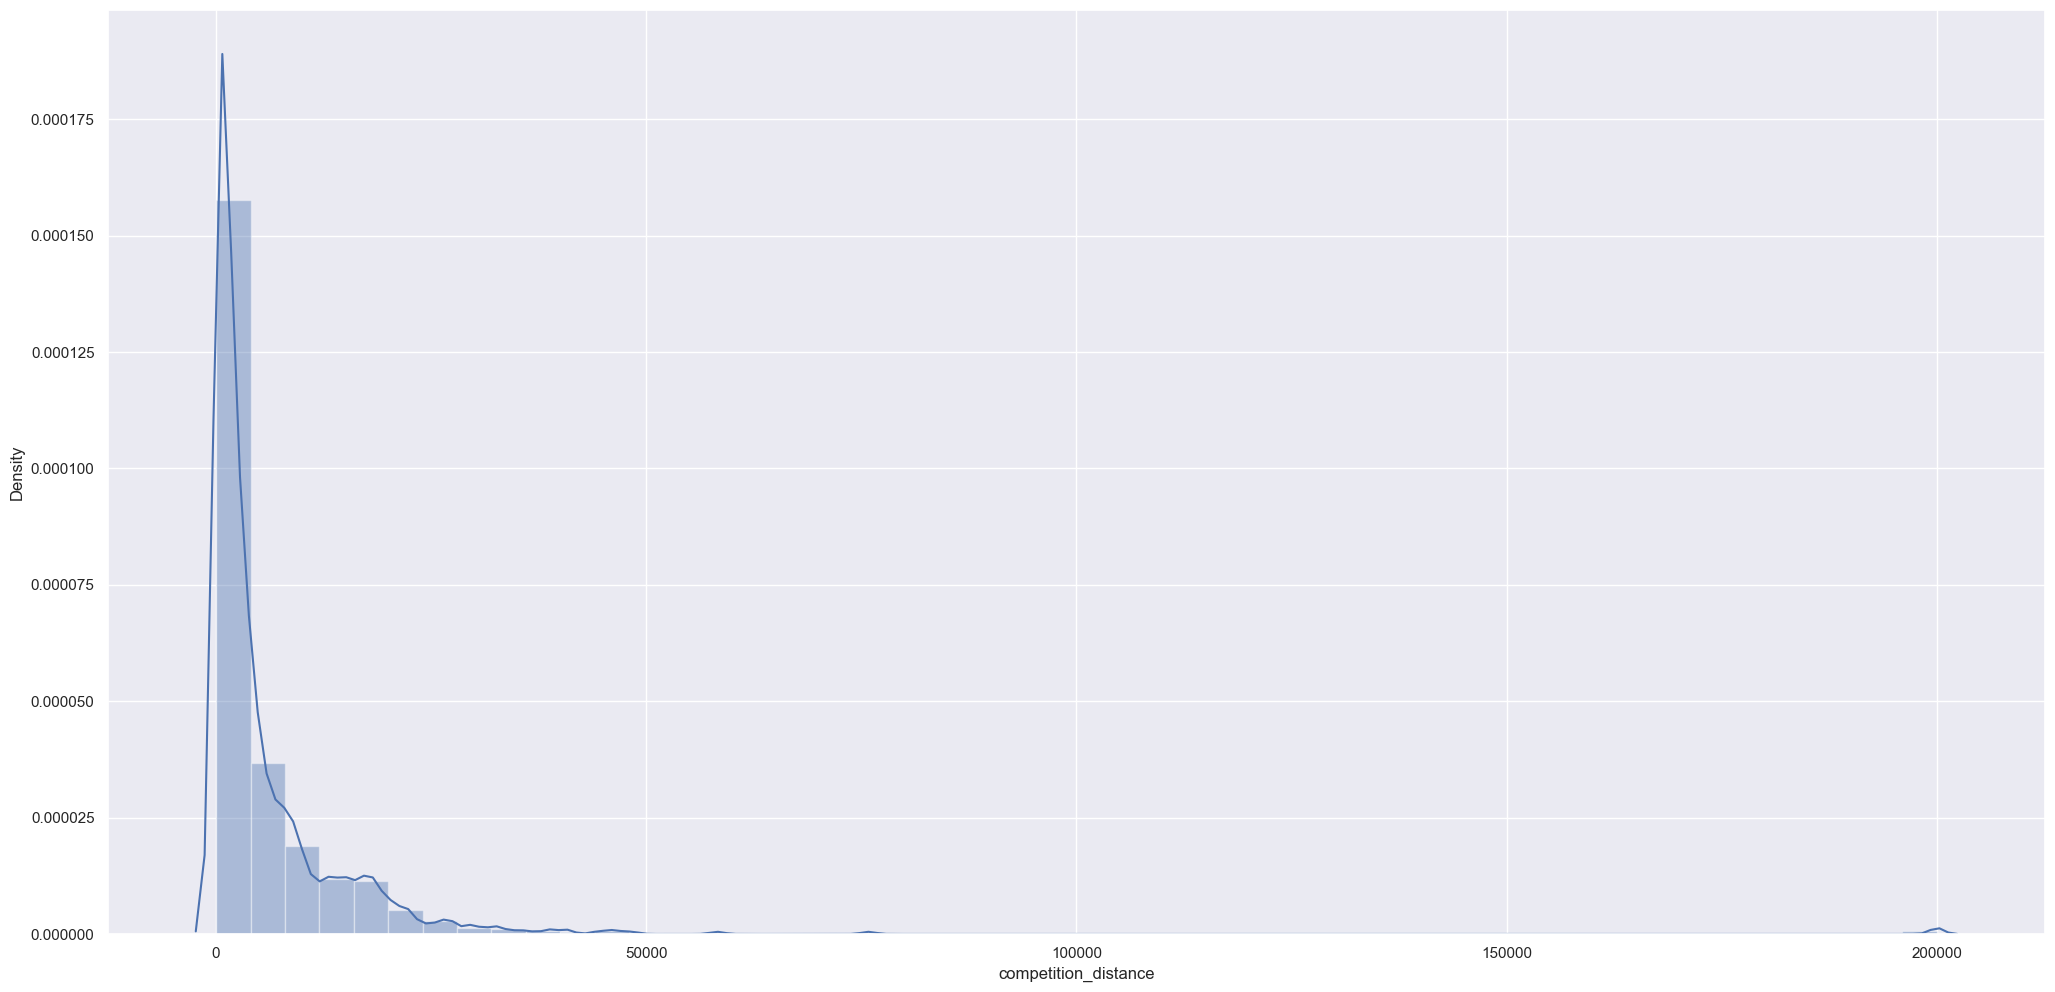

In [112]:
sns.distplot( df1['competition_distance'])

## 1.7.2. Categorical Attributes

In [113]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

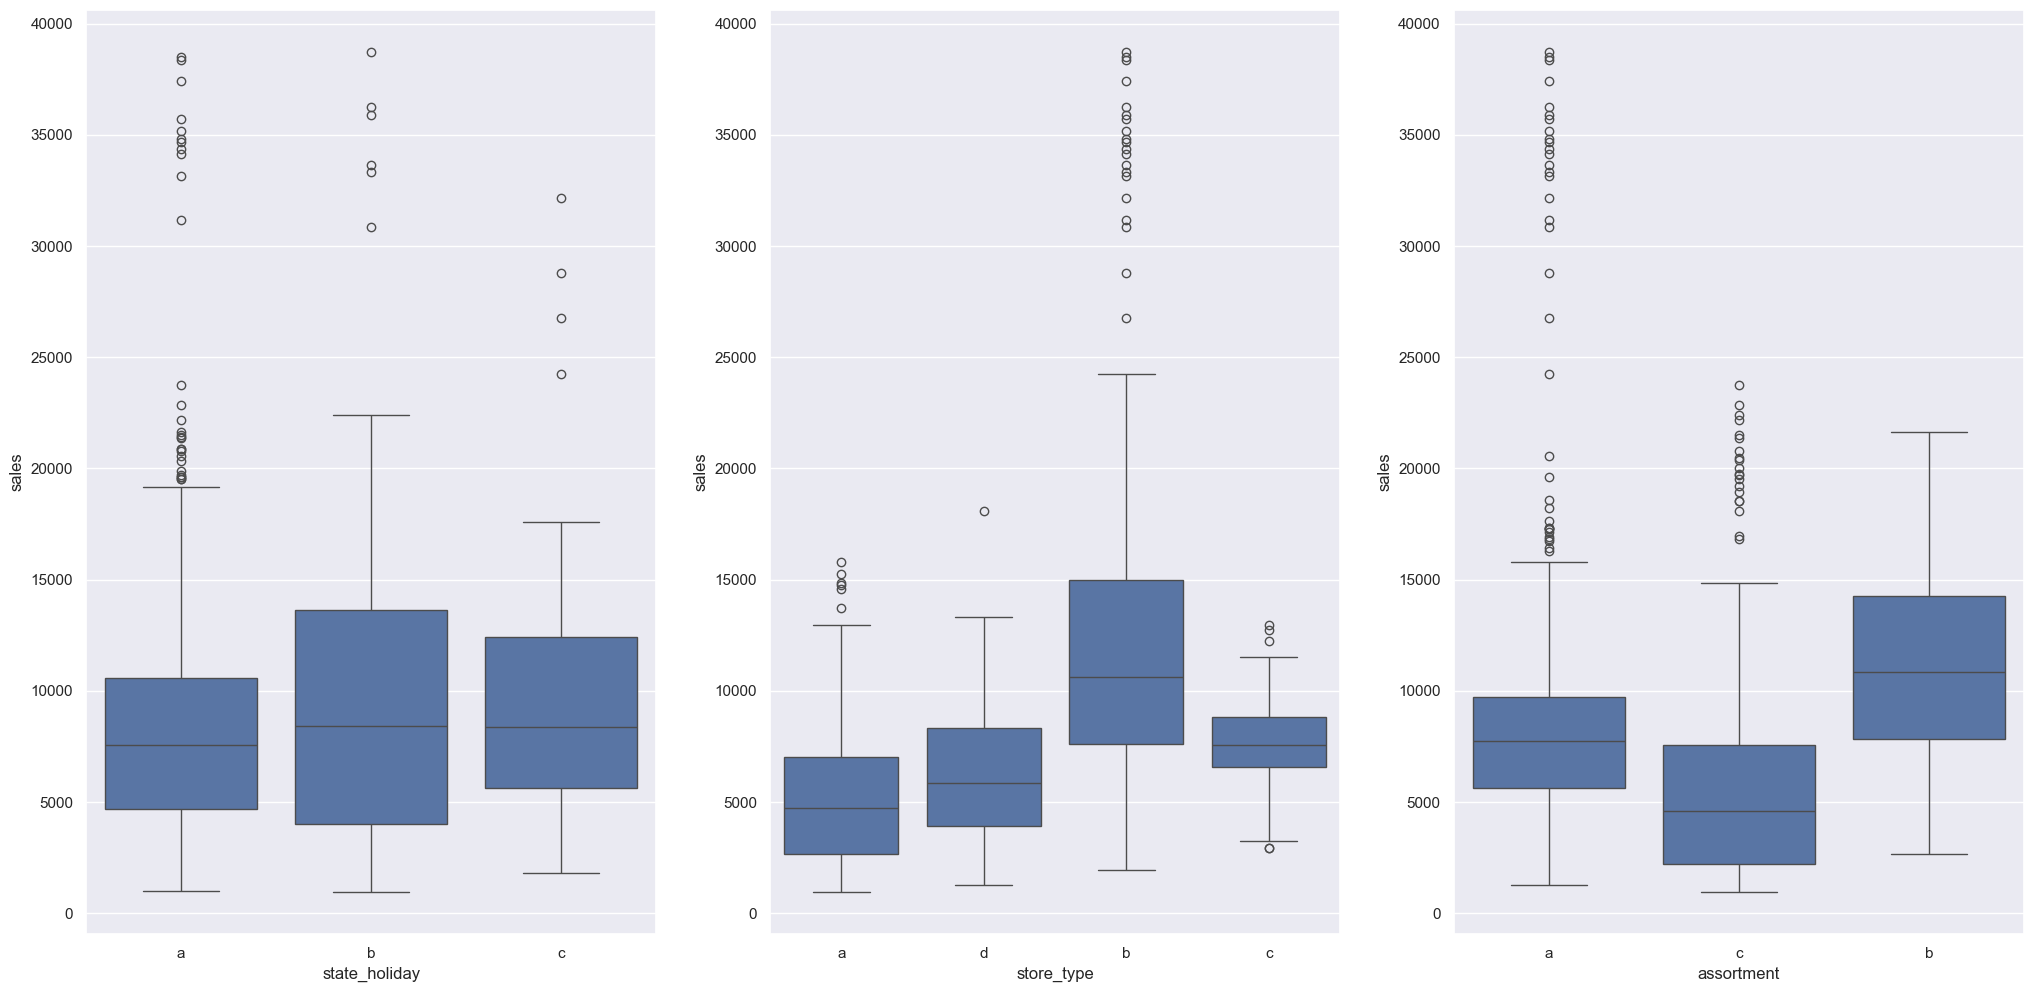

In [114]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [115]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

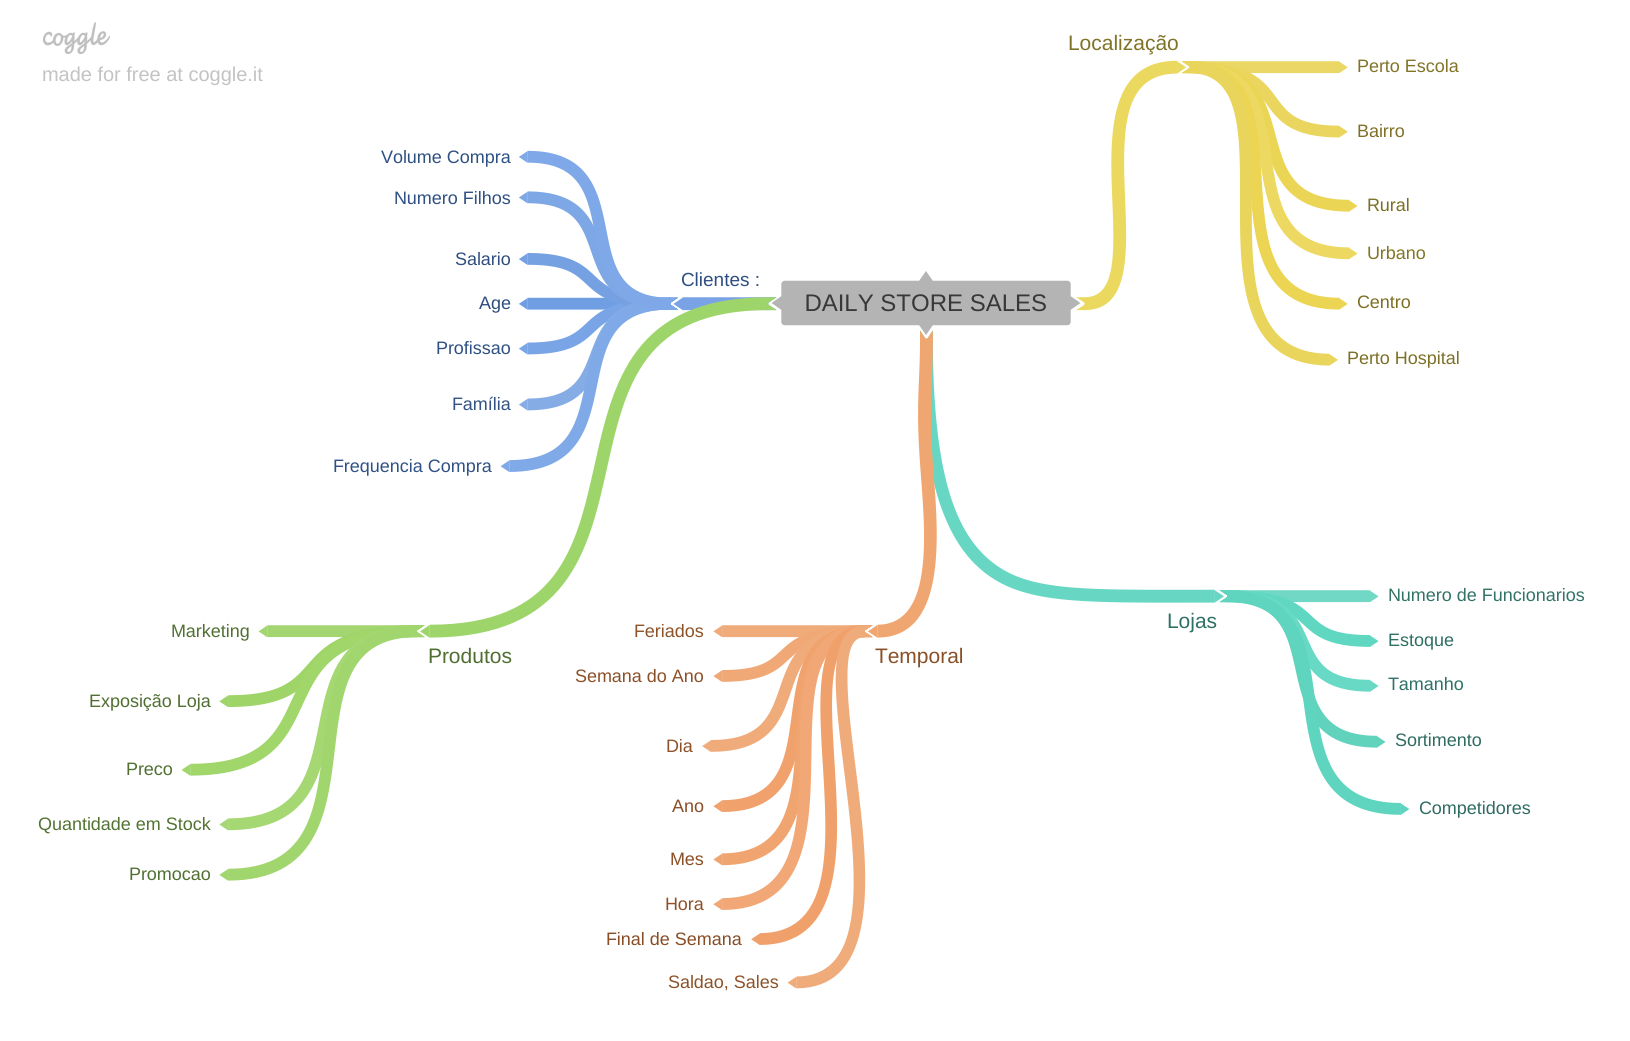

In [116]:
Image( 'img/MindMapHypothesis.png' )

## 2.2. Criacao das Hipoteses

### 2.2.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promoções mais ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.
    
**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções mais ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [117]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [118]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [119]:
df3 = df2.copy()

In [120]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [121]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [122]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1) #deletar estas colunas

In [123]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [124]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

C:\Users\Admin\AppData\Local\Temp\ipykernel_4392\263841694.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'], kde=False)


<Axes: xlabel='sales'>

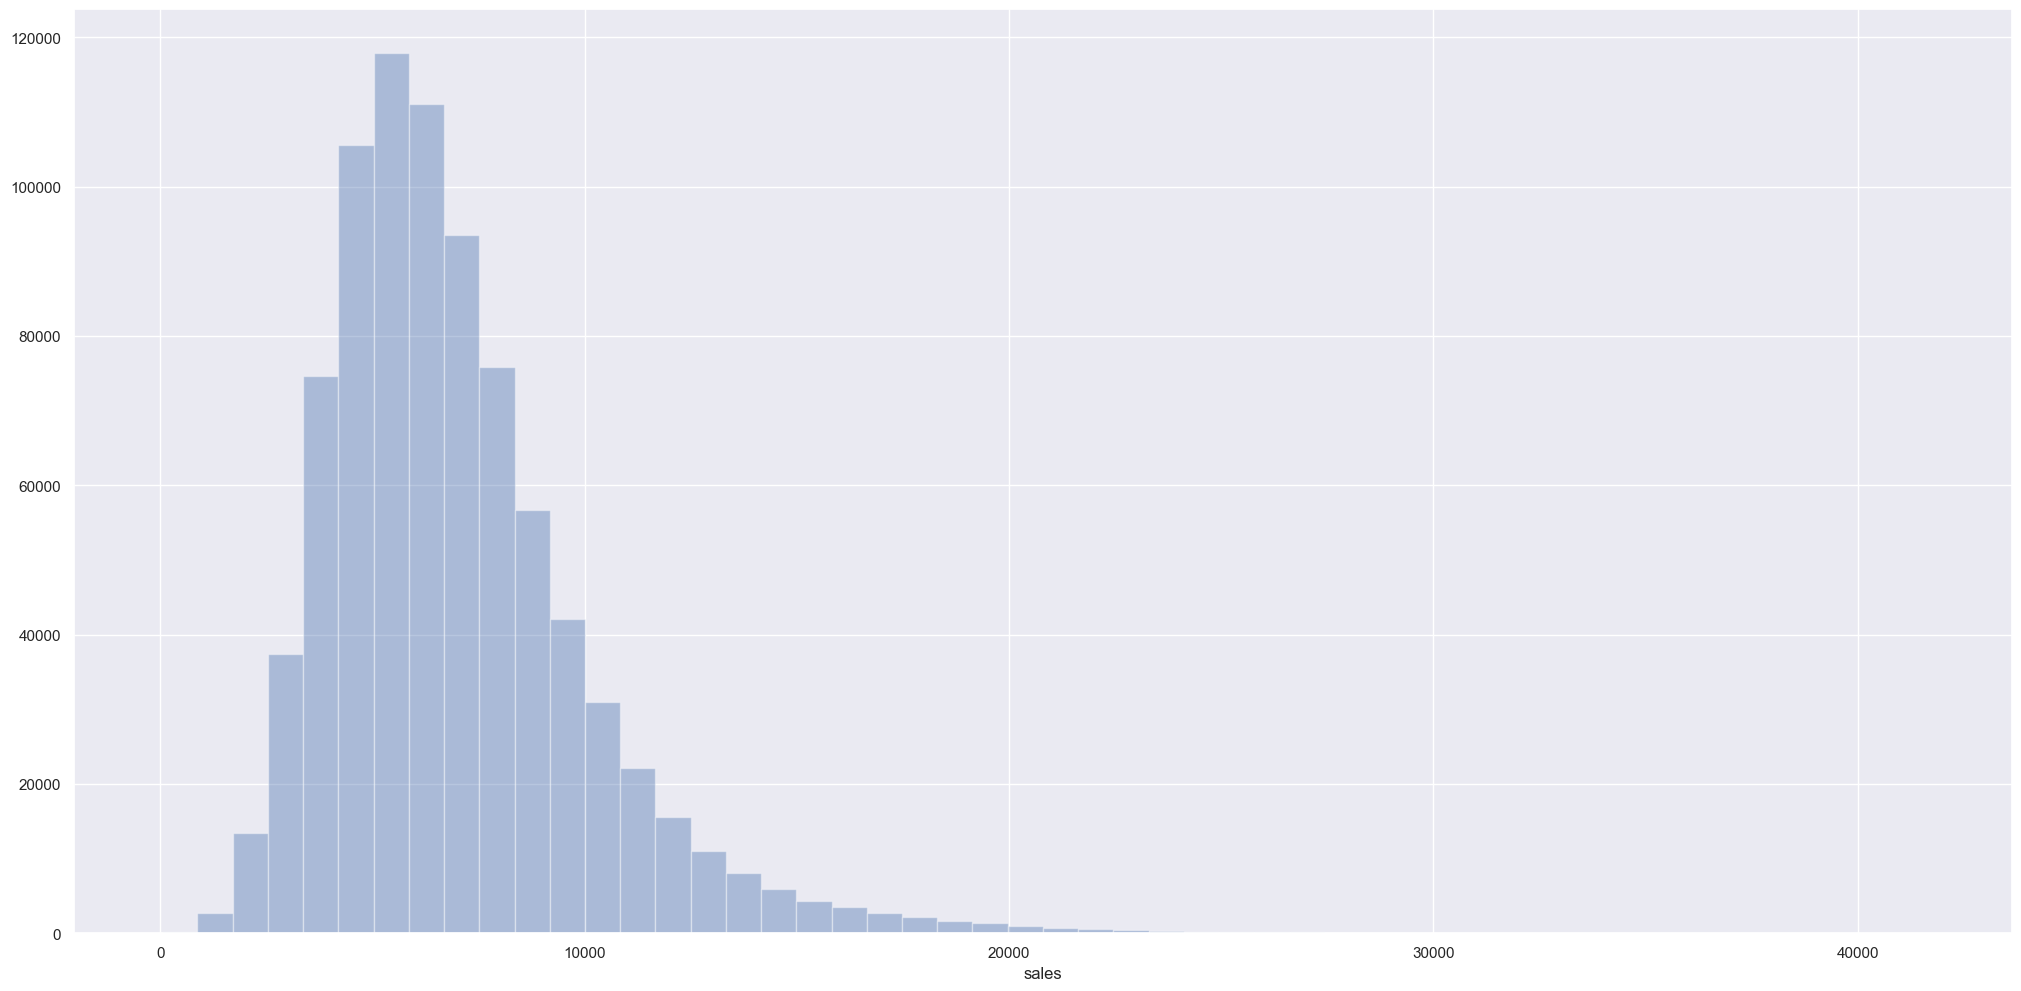

In [125]:
sns.distplot(df4['sales'], kde=False)

### 4.1.2. Numerical Variable

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>],
       [<Axes: title={'center': 'customers'}>,
        <Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>],
       [<Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>,
        <Axes: title={'center': 'promo2'}>],
       [<Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

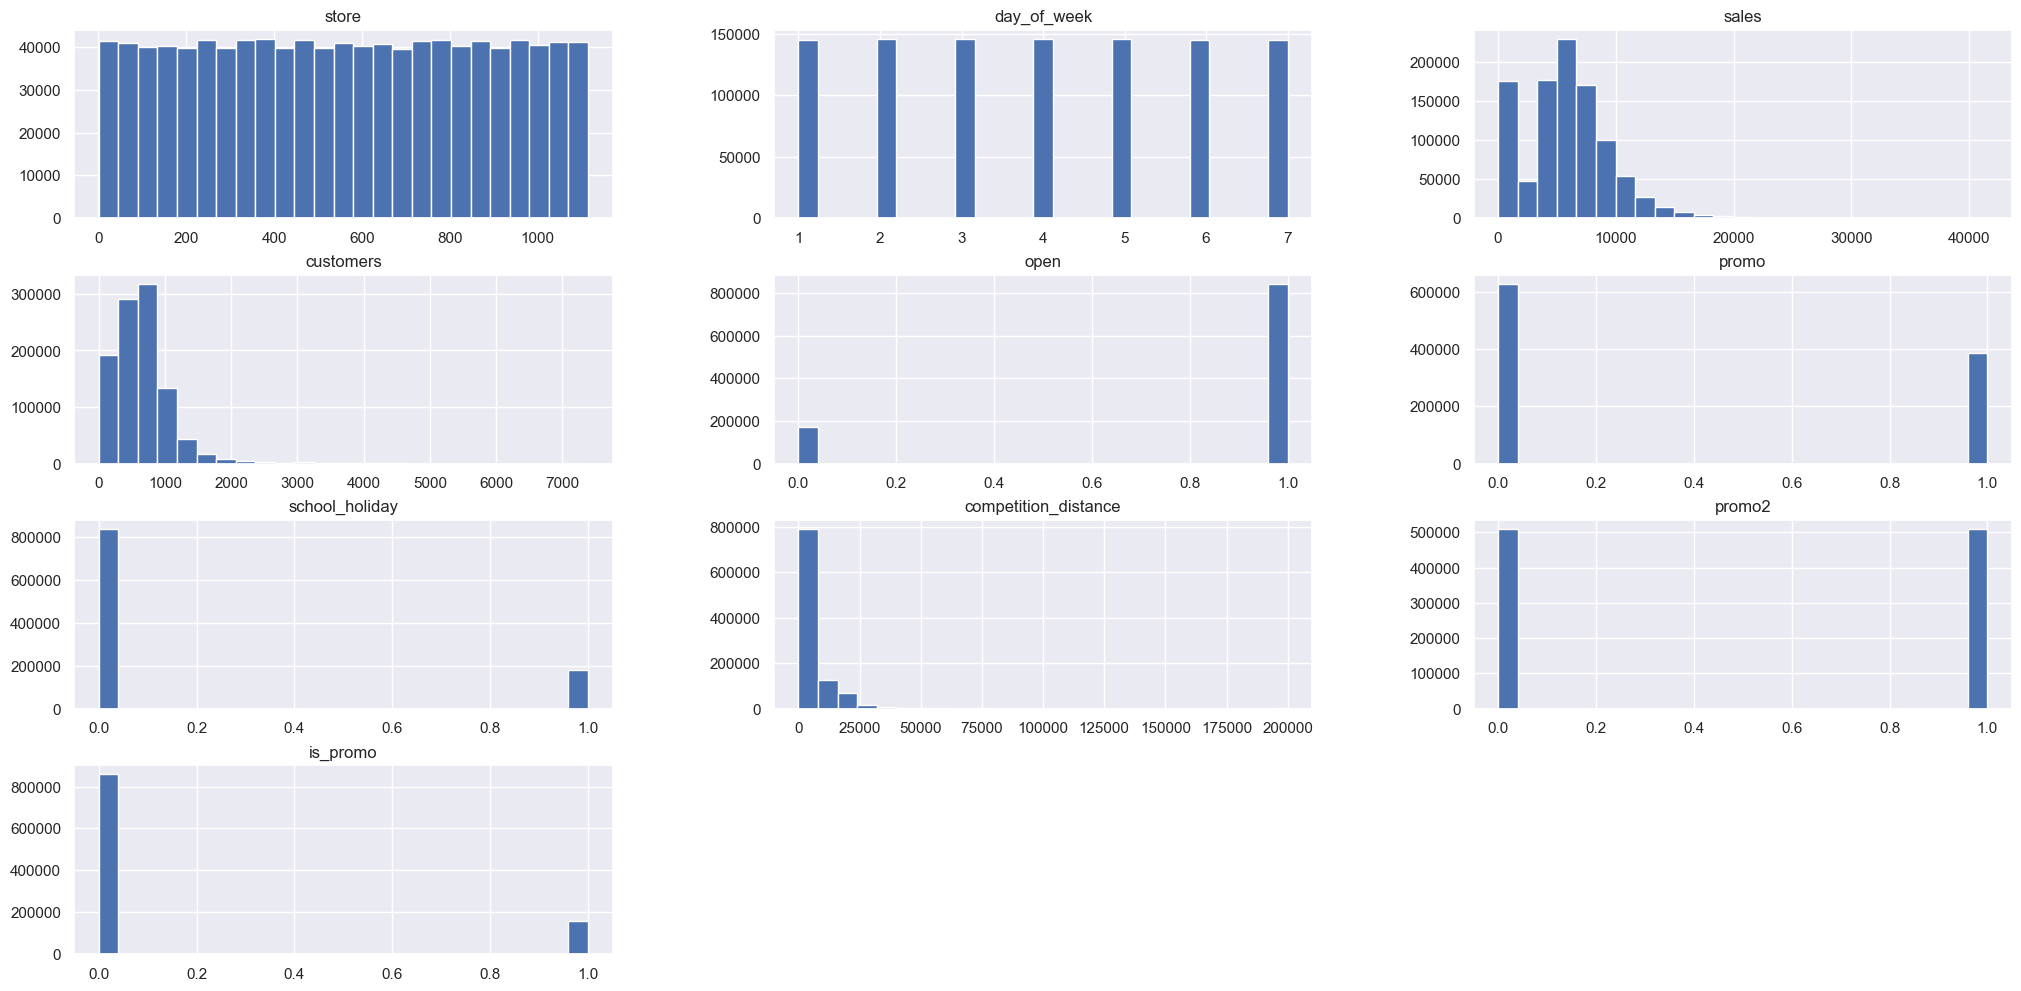

In [126]:
num_attributes.hist( bins=25 ) #bin é como se fosse uma caixa para colocar o seu conjunto de dados

### 4.1.3. Categorical Variable

In [127]:
cat_attributes.head()

,state_holiday,store_type,assortment,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year,promo_interval,month_map
0,0,c,a,9,2008,31,2015,0,Jul
1,0,a,a,11,2007,13,2010,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,12,2006,14,2011,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,9,2009,31,2015,0,Jul
4,0,a,a,4,2015,31,2015,0,Jul


In [128]:
df4['state_holiday'].drop_duplicates() #ficar com os tipos de variaveis categoricas originais

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [129]:
df4['store_type'].drop_duplicates() #ficar com os tipos de variaveis categoricas originais

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [130]:
df4['assortment'].drop_duplicates() #ficar com os tipos de variaveis categoricas originais

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\Admin\AppData\Local\Temp\ipykernel_4392\3753212517.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',shade=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_4392\3753212517.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',shade=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_4392\3753212517.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas',shade=True)
C:\Users\Admin\AppData\Local\

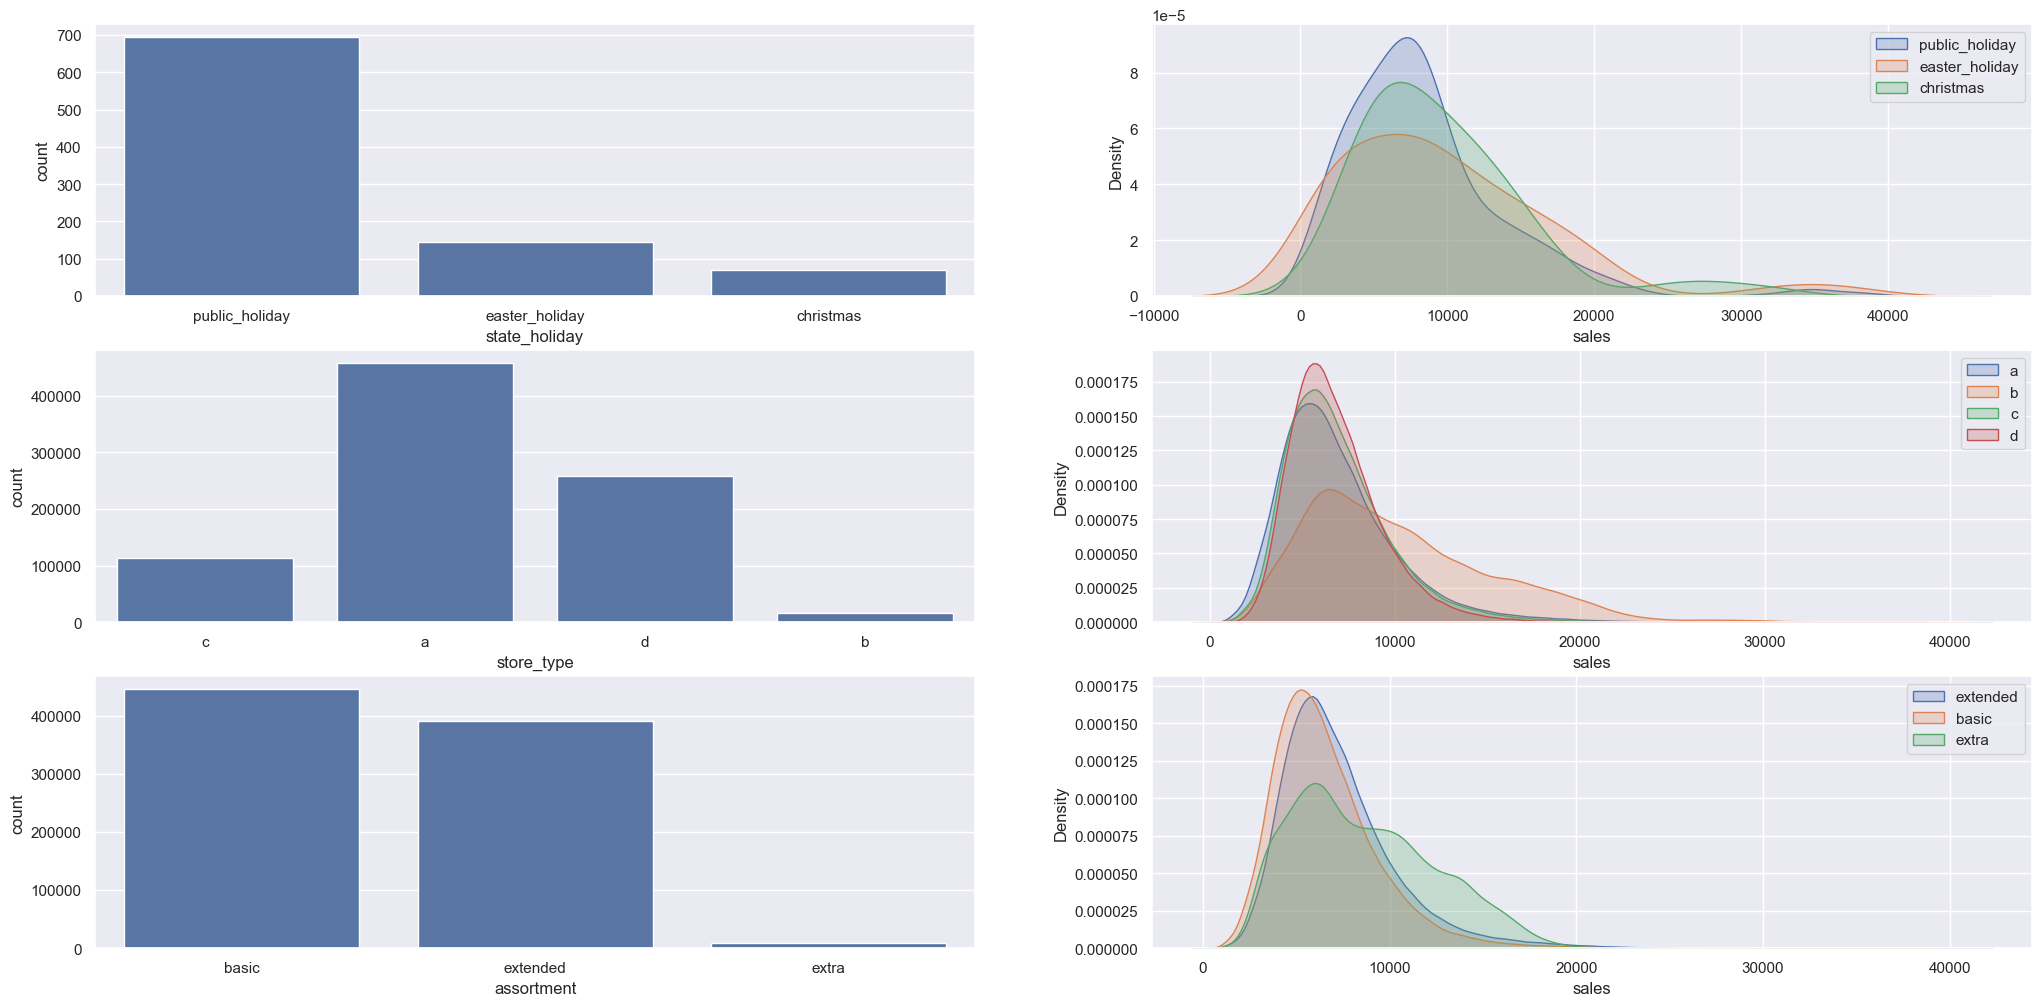

In [131]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=a)

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas',shade=True)
plt.legend()

# store_type
plt.subplot(3, 2, 3)
sns.countplot( x='store_type', data=df4)

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d',shade=True)
plt.legend()

# assortment
plt.subplot(3, 2, 5)
sns.countplot( x='assortment', data=df4)

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True)
plt.legend()


In [132]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

## 4.2. Analise Bivariada

**H1.** Lojas com maior sortimentos deveriam vender mais.
<br>**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

<Axes: xlabel='year_week'>

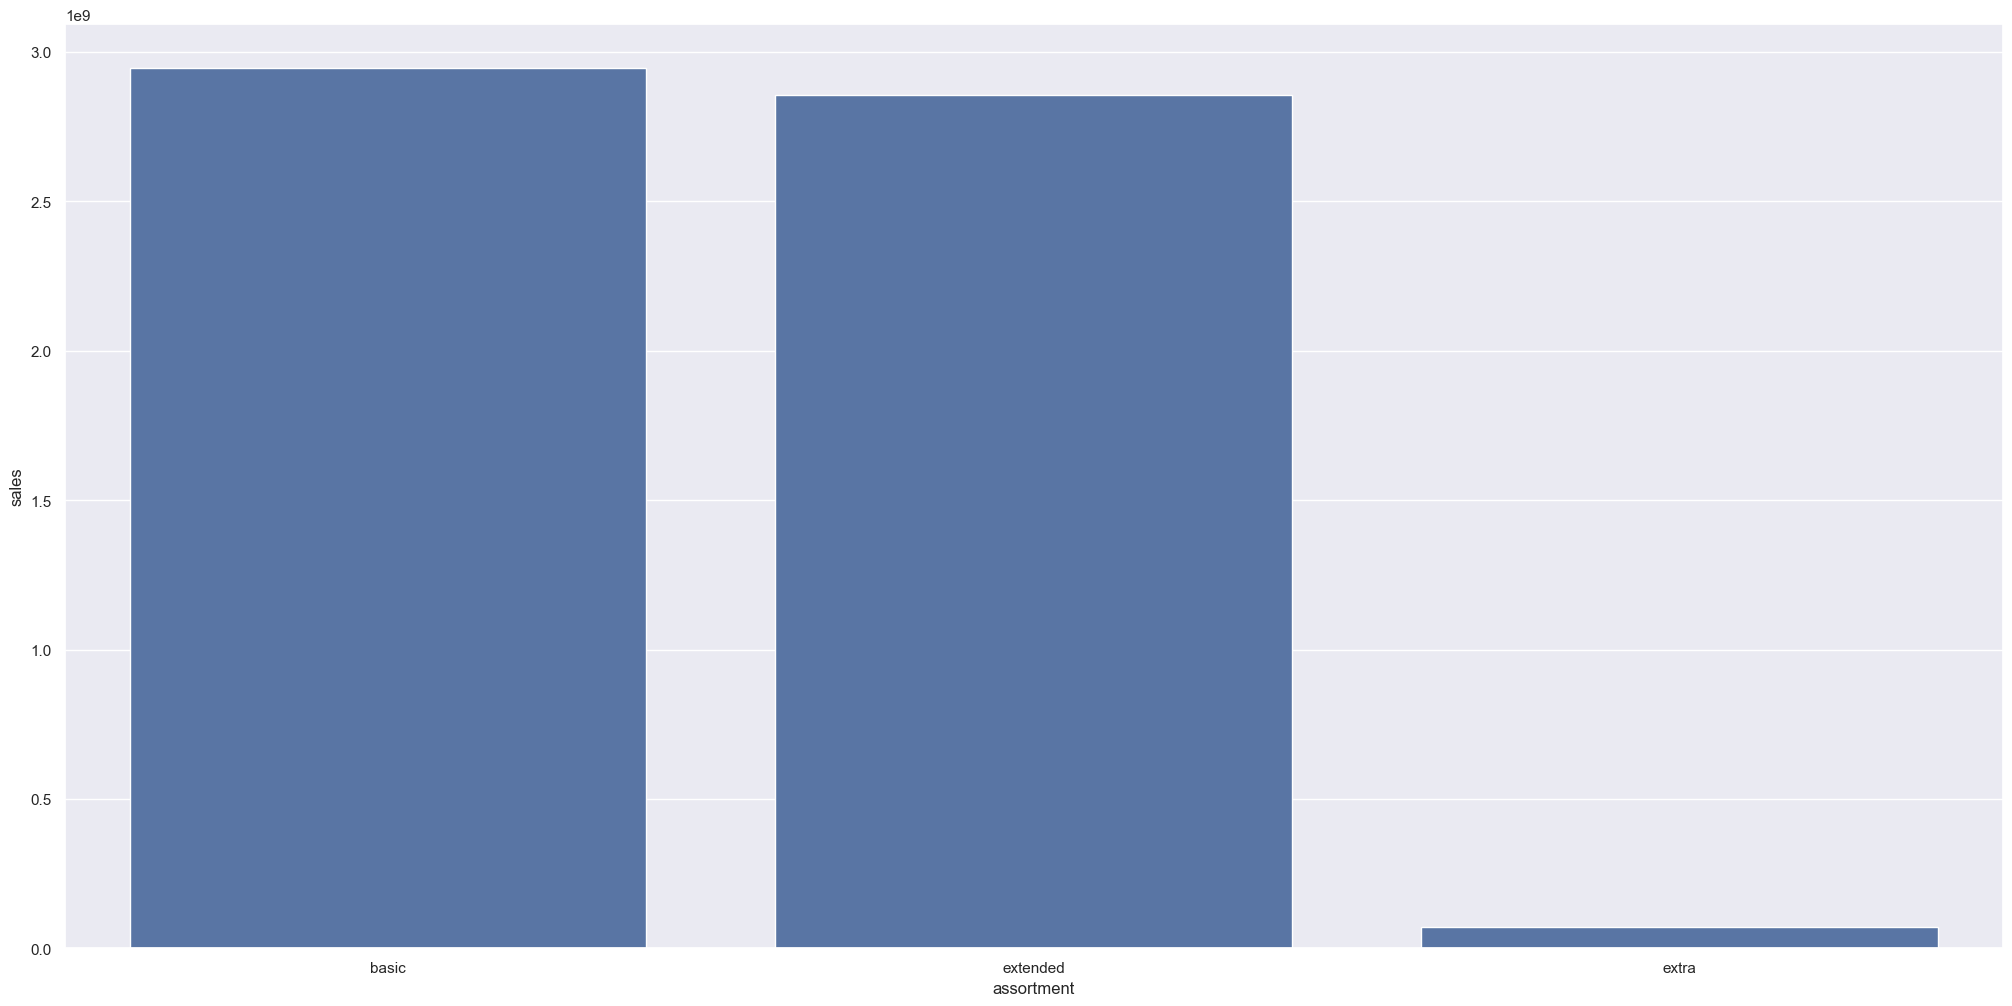

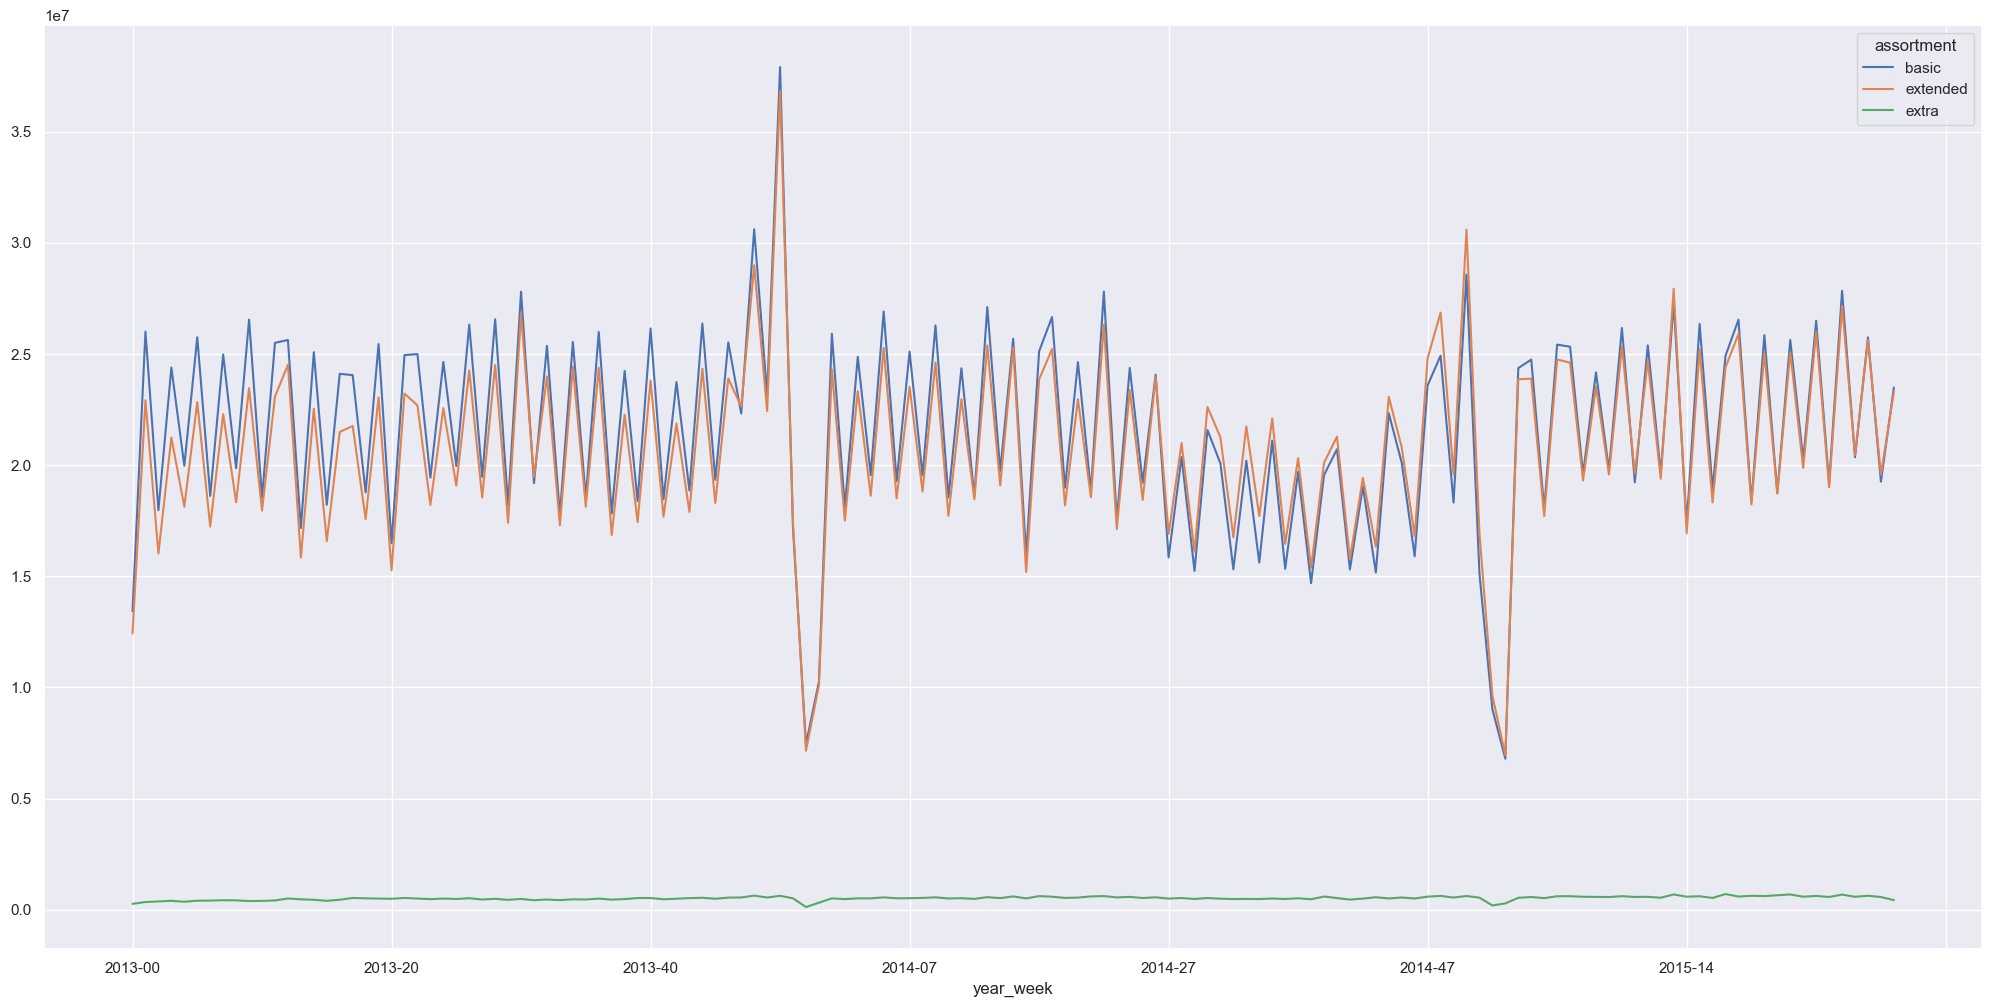

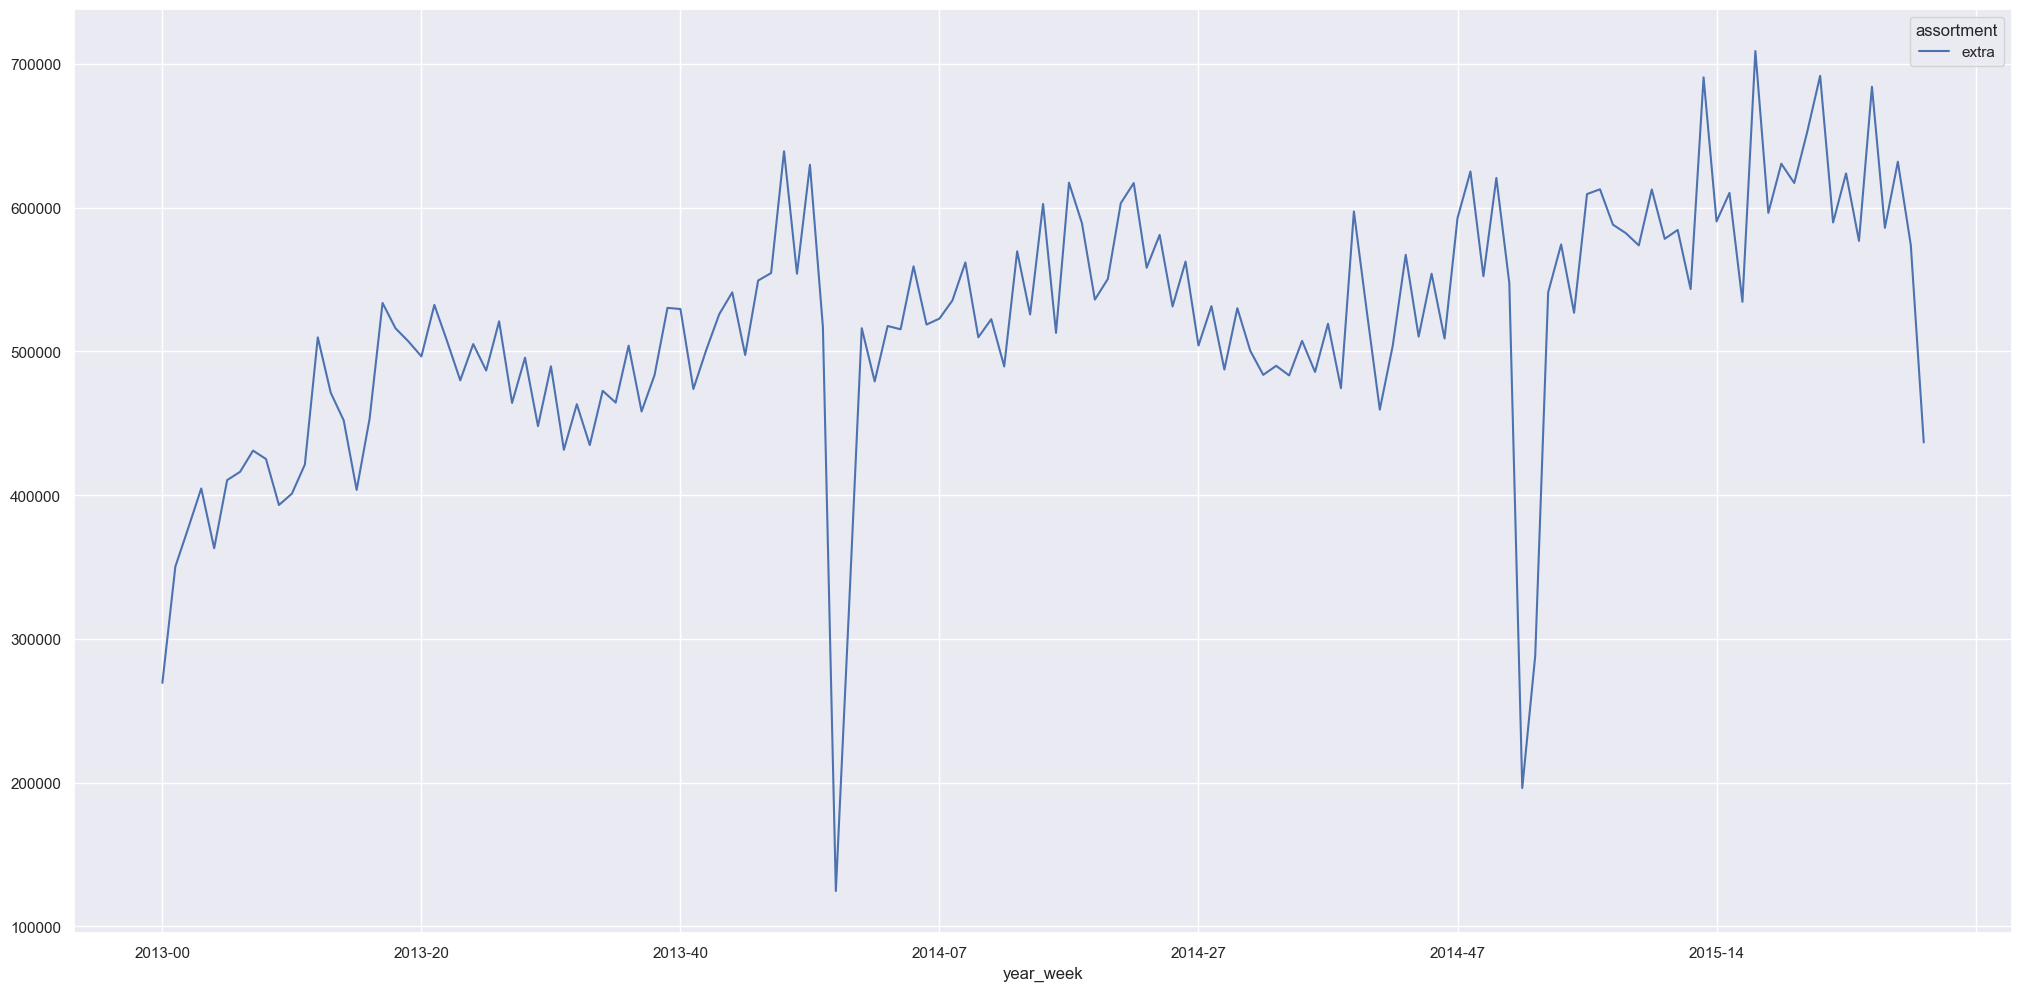

In [133]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

**H2.** Lojas com competidores mais próximos deveriam vender menos.
<br>**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

C:\Users\Admin\AppData\Local\Temp\ipykernel_4392\3406209799.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()


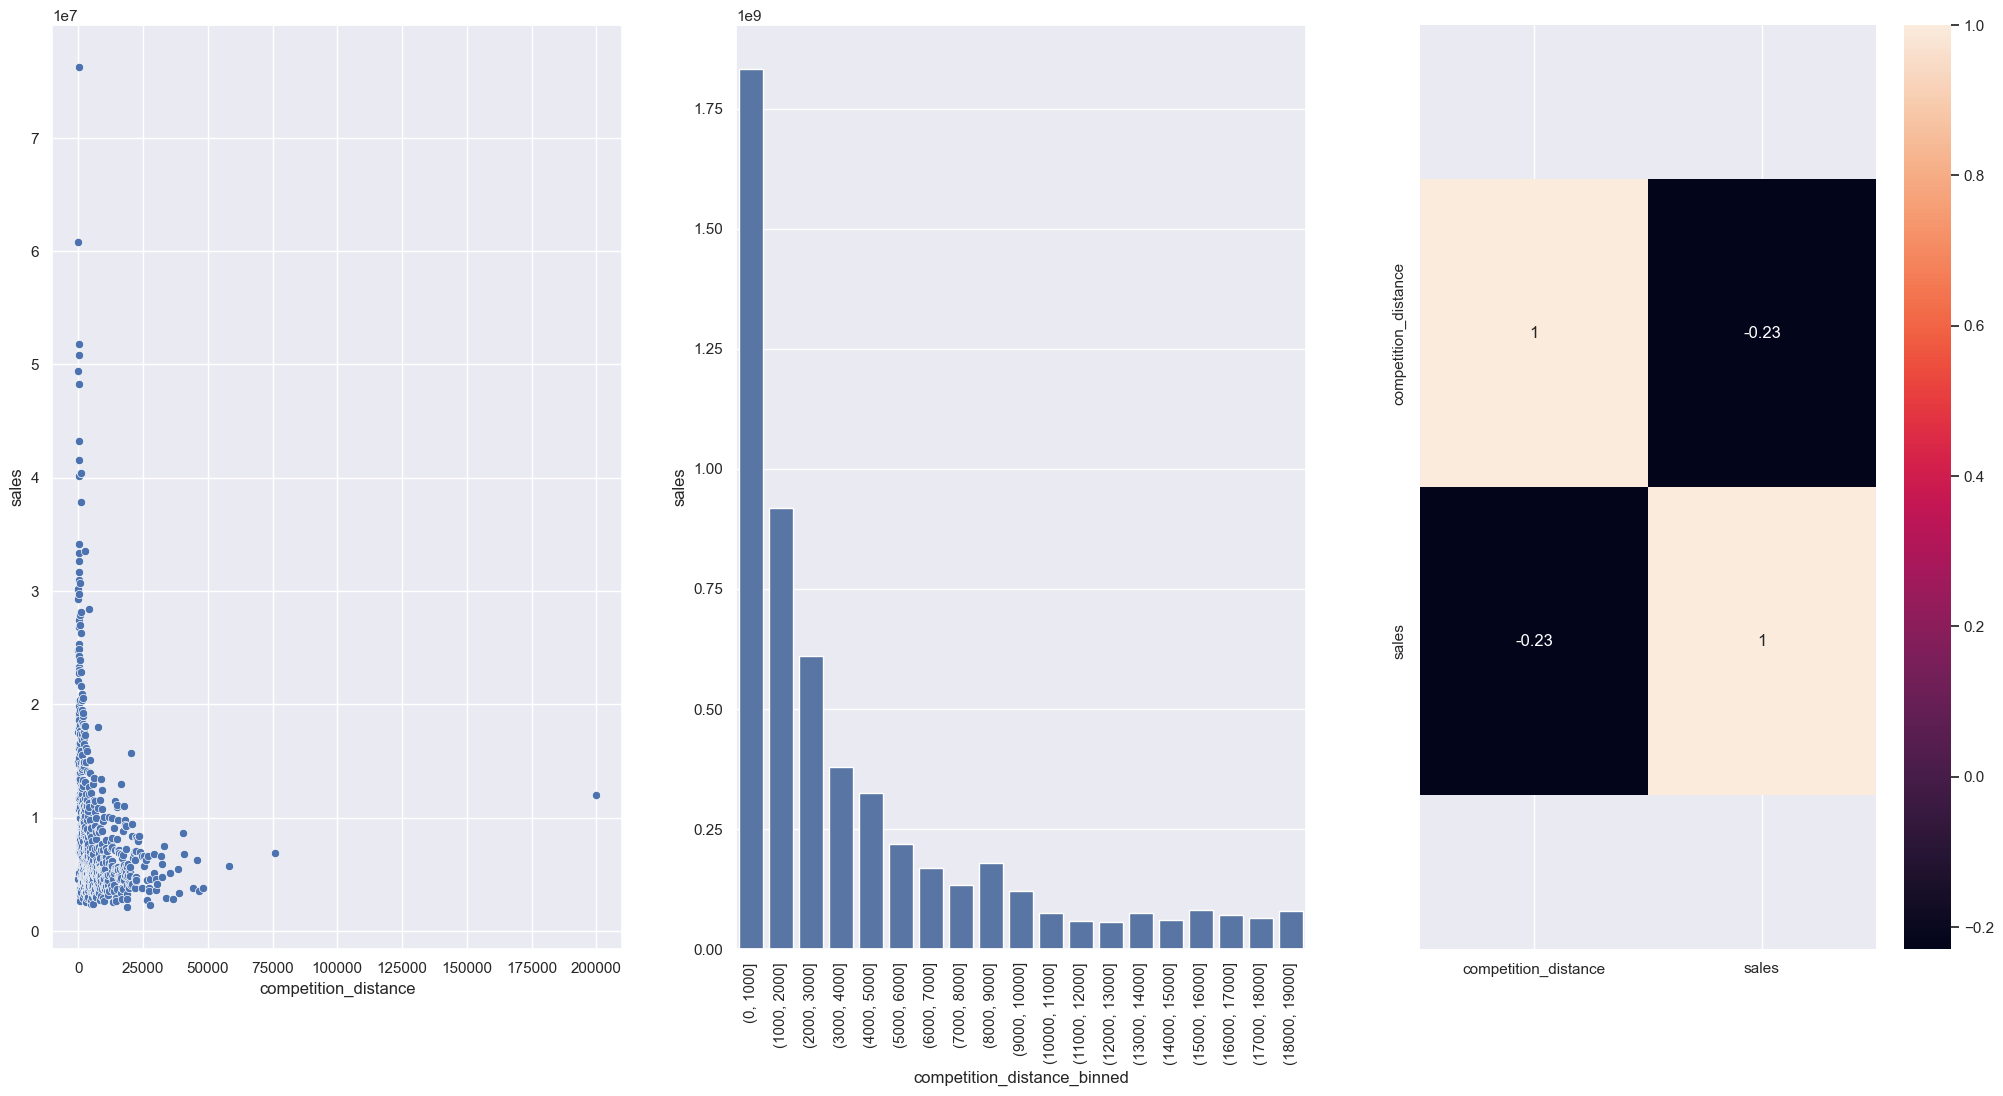

In [134]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000)) #numeros arbitrarios
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson', numeric_only=True), annot=True);
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

In [135]:
aux1.head()

,competition_distance,sales,competition_distance_binned
0,20.0,4579807,"(0, 1000]"
1,30.0,17552666,"(0, 1000]"
2,40.0,29261626,"(0, 1000]"
3,50.0,60835848,"(0, 1000]"
4,60.0,22088359,"(0, 1000]"


**H3.** Lojas com competidores à mais tempo deveriam vender mais.
<br>**FALSA** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

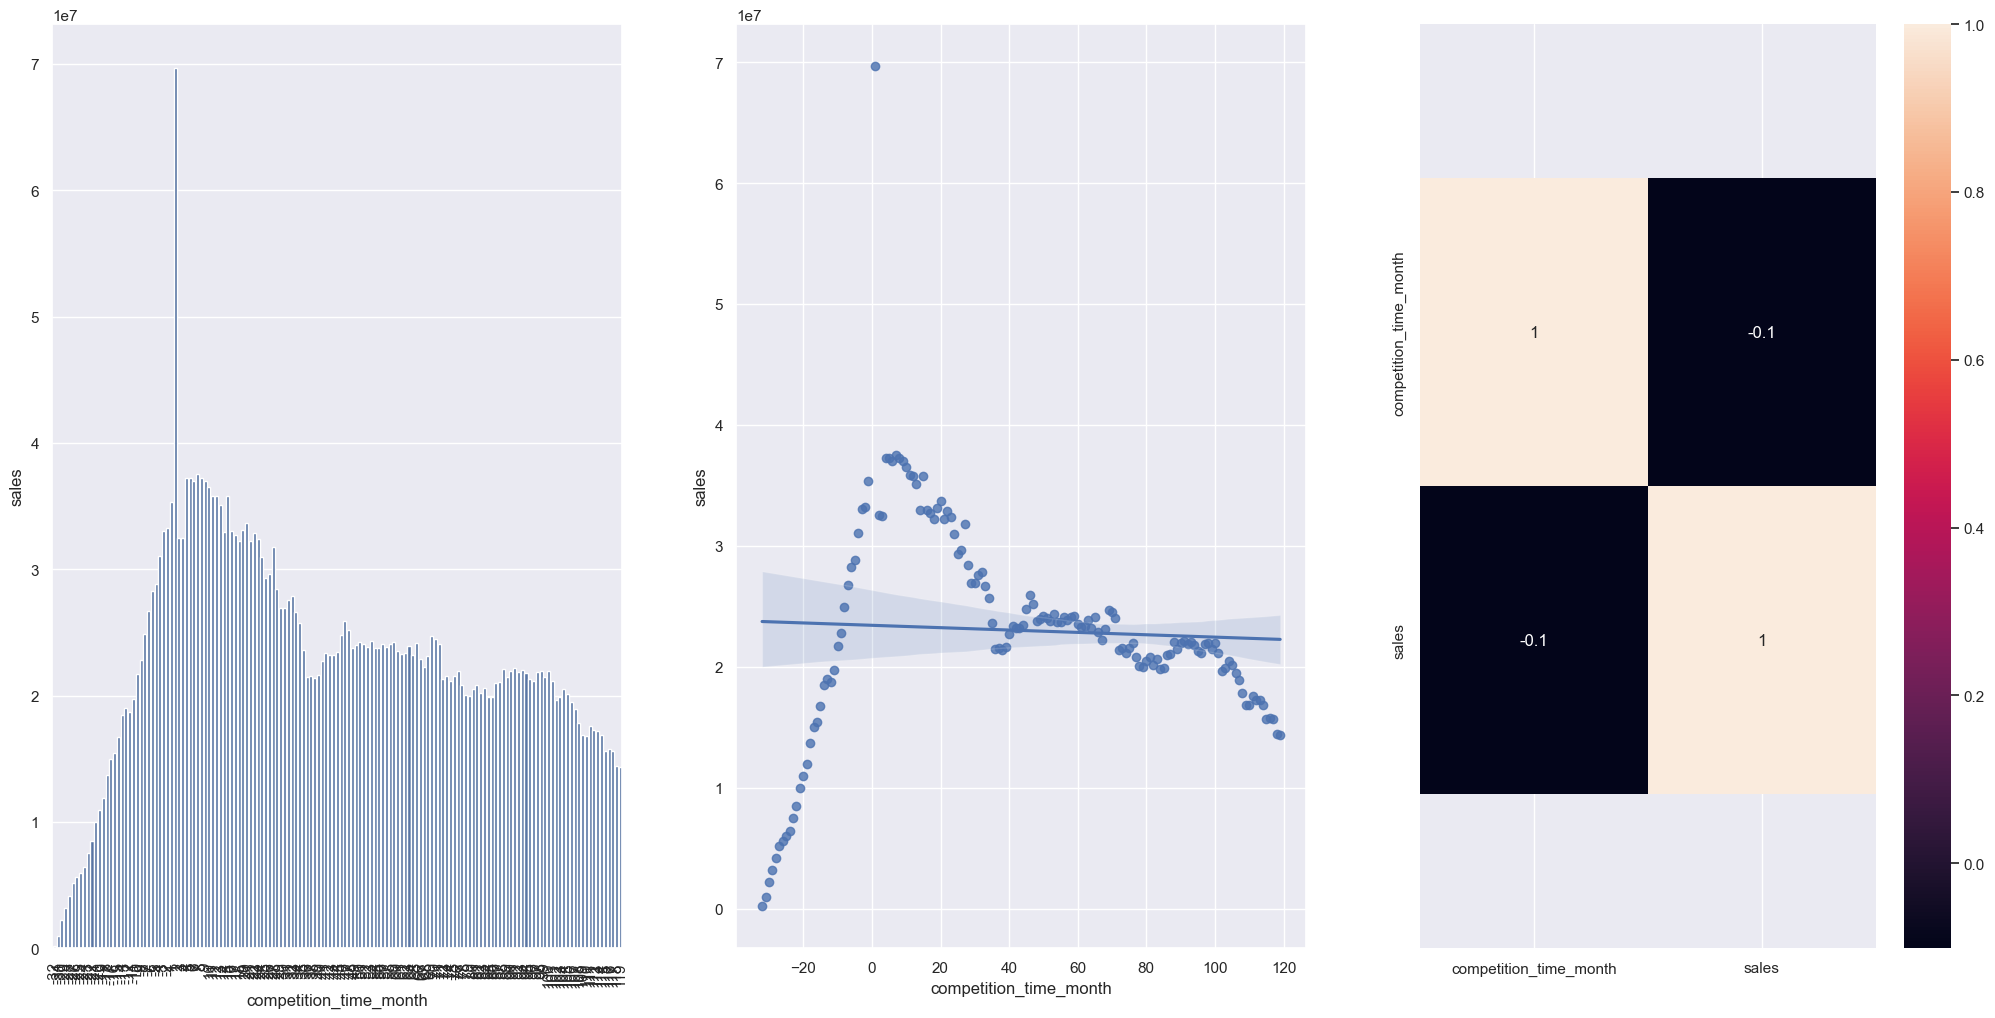

In [136]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

**H4.** Lojas com promoções mais ativas por mais tempo deveriam vender mais.<br> **FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao.

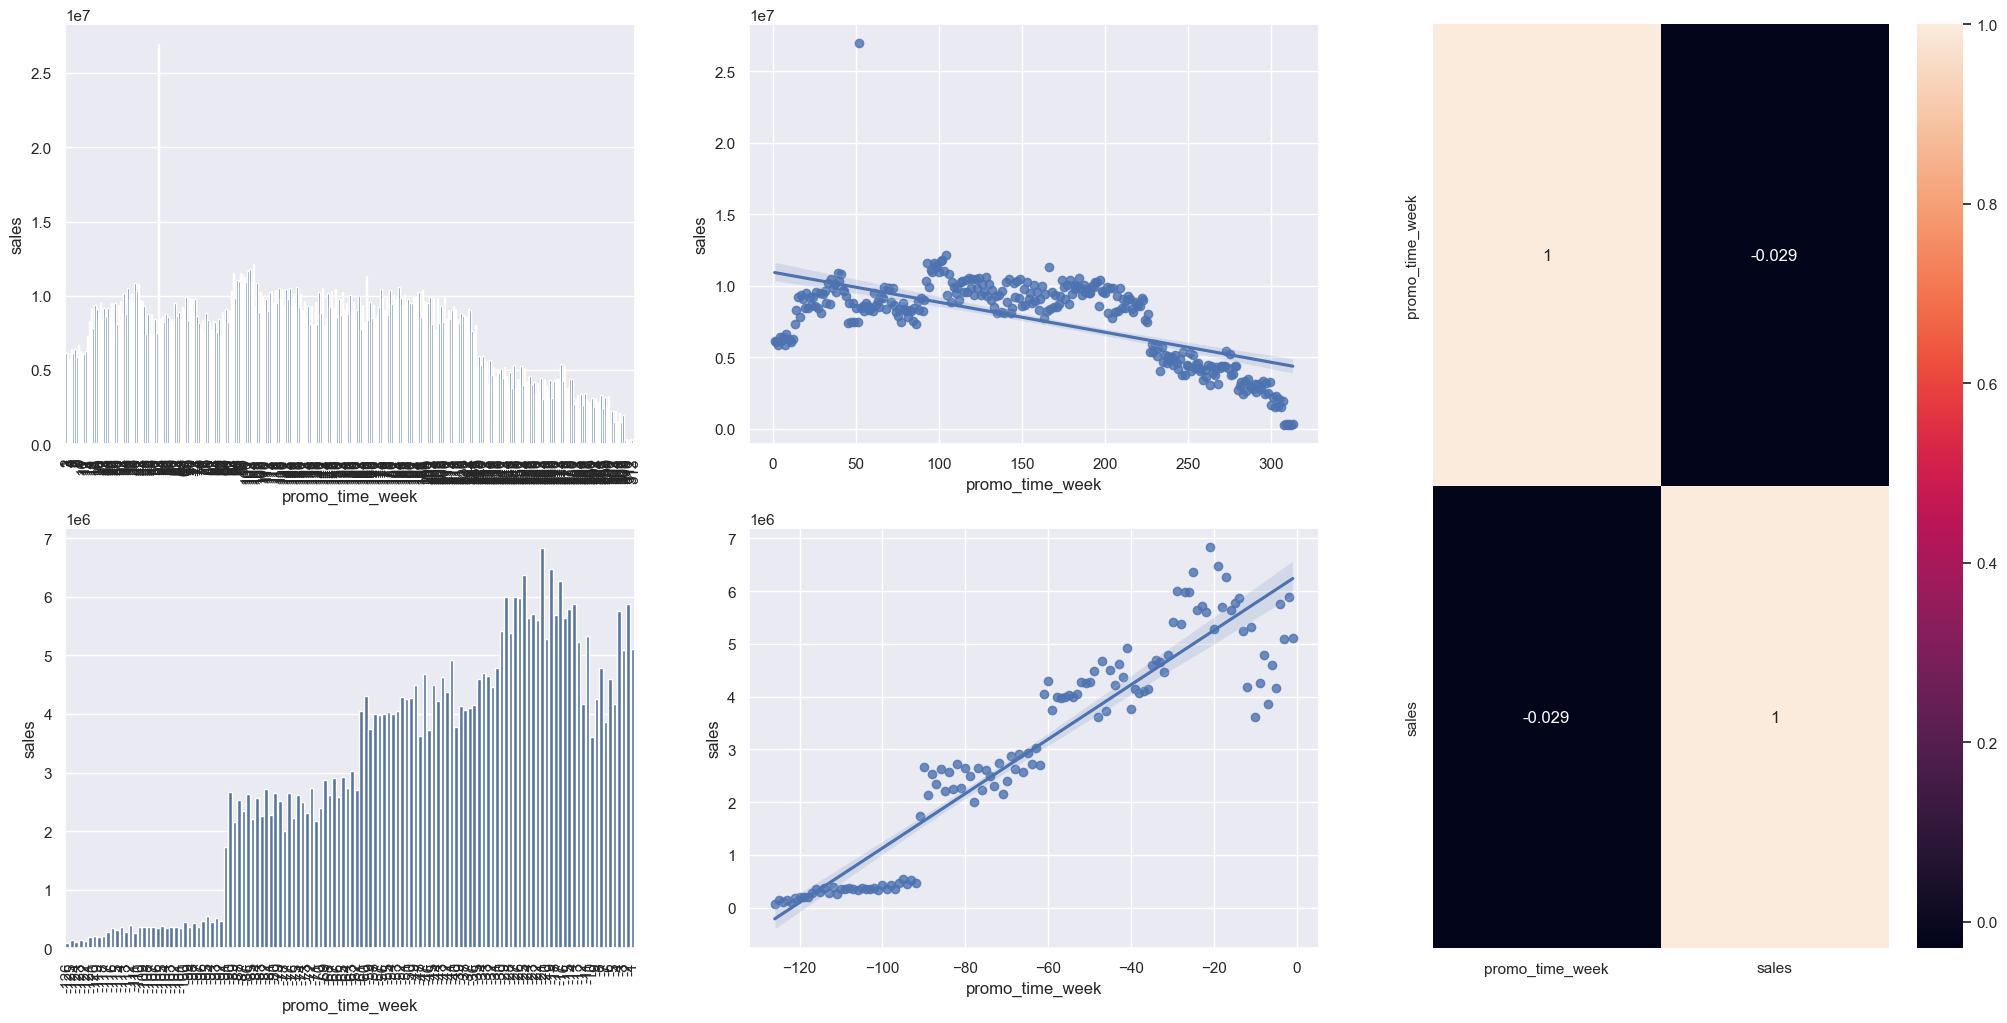

In [137]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] #promocao extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot( grid[0,1] )
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] #promocao regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot( grid[1,1] )
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot( grid[:,2] )
sns.heatmap(aux1.corr(method='pearson'), annot=True);

###<s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

**H6.** Lojas com mais promoções consecutivas deveriam vender mais.
<br>**FALSA** Lojas com mais promocoes consecutivas vendem menos.

In [138]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


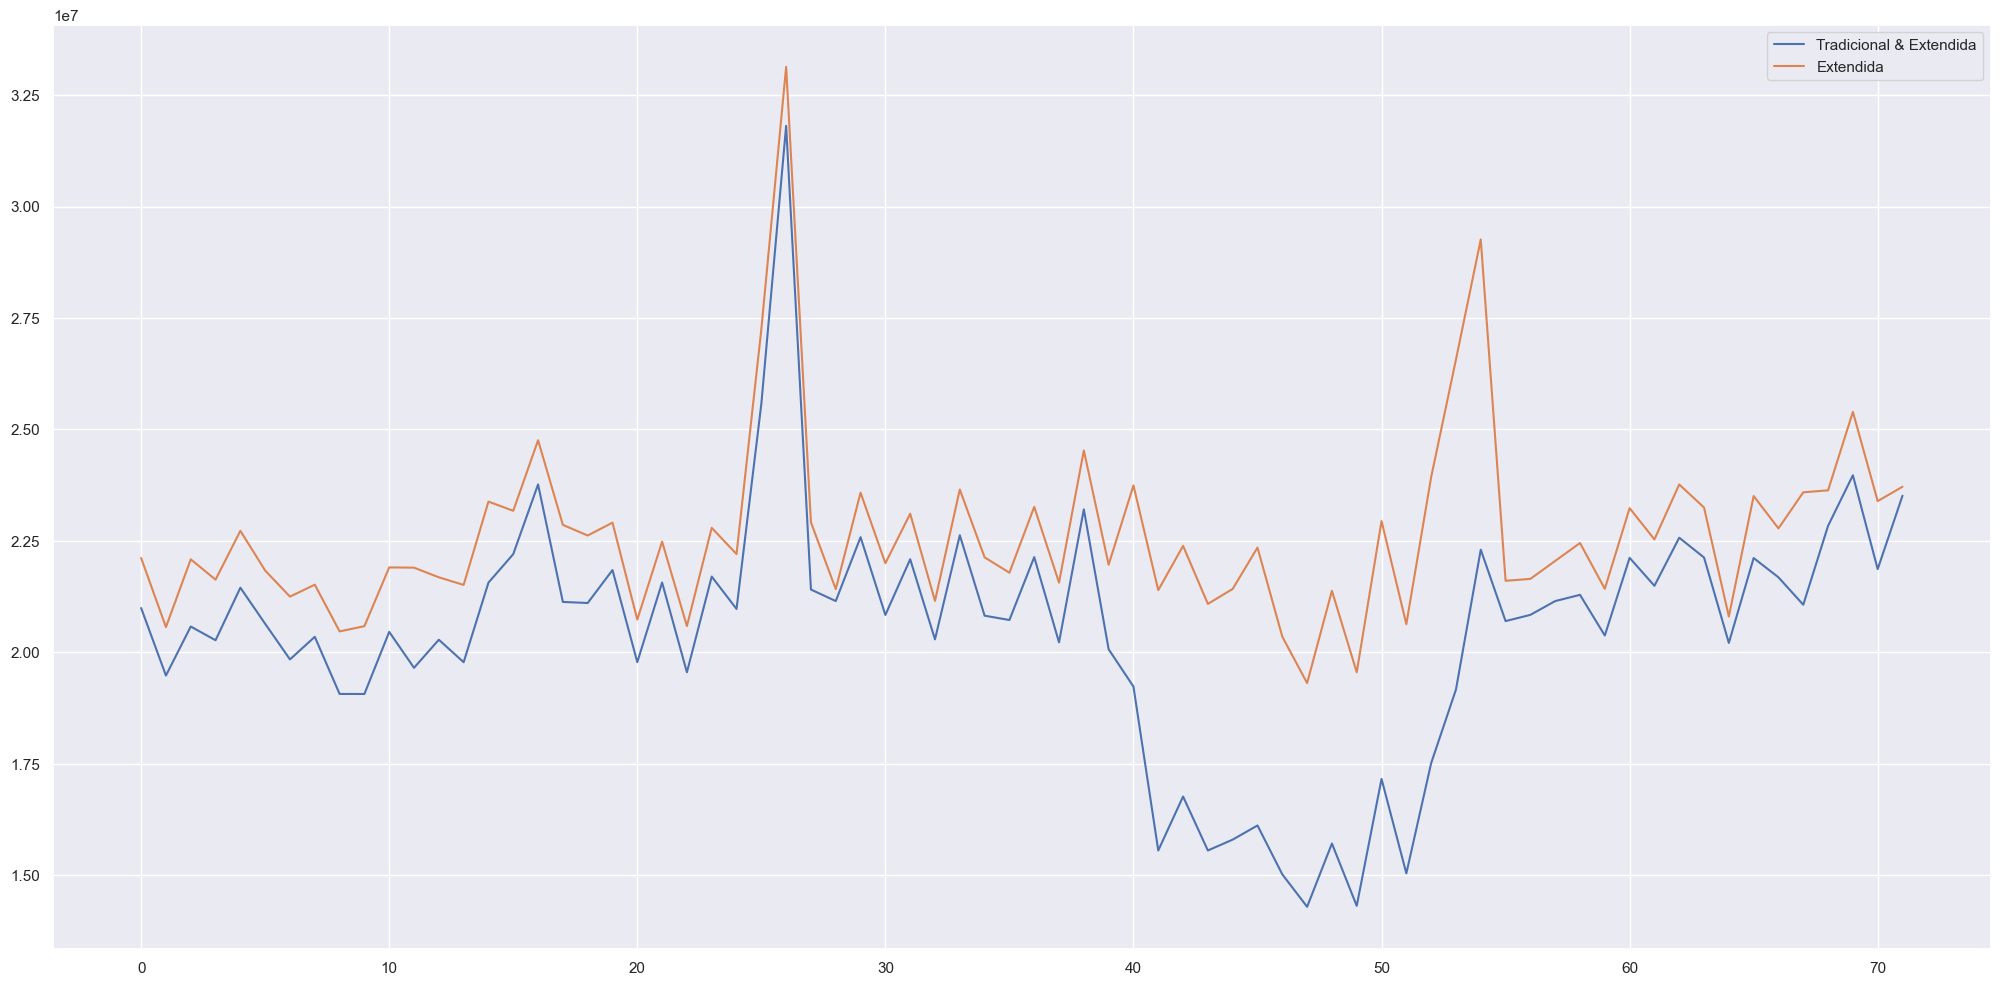

In [139]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax )

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

**H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
<br>**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

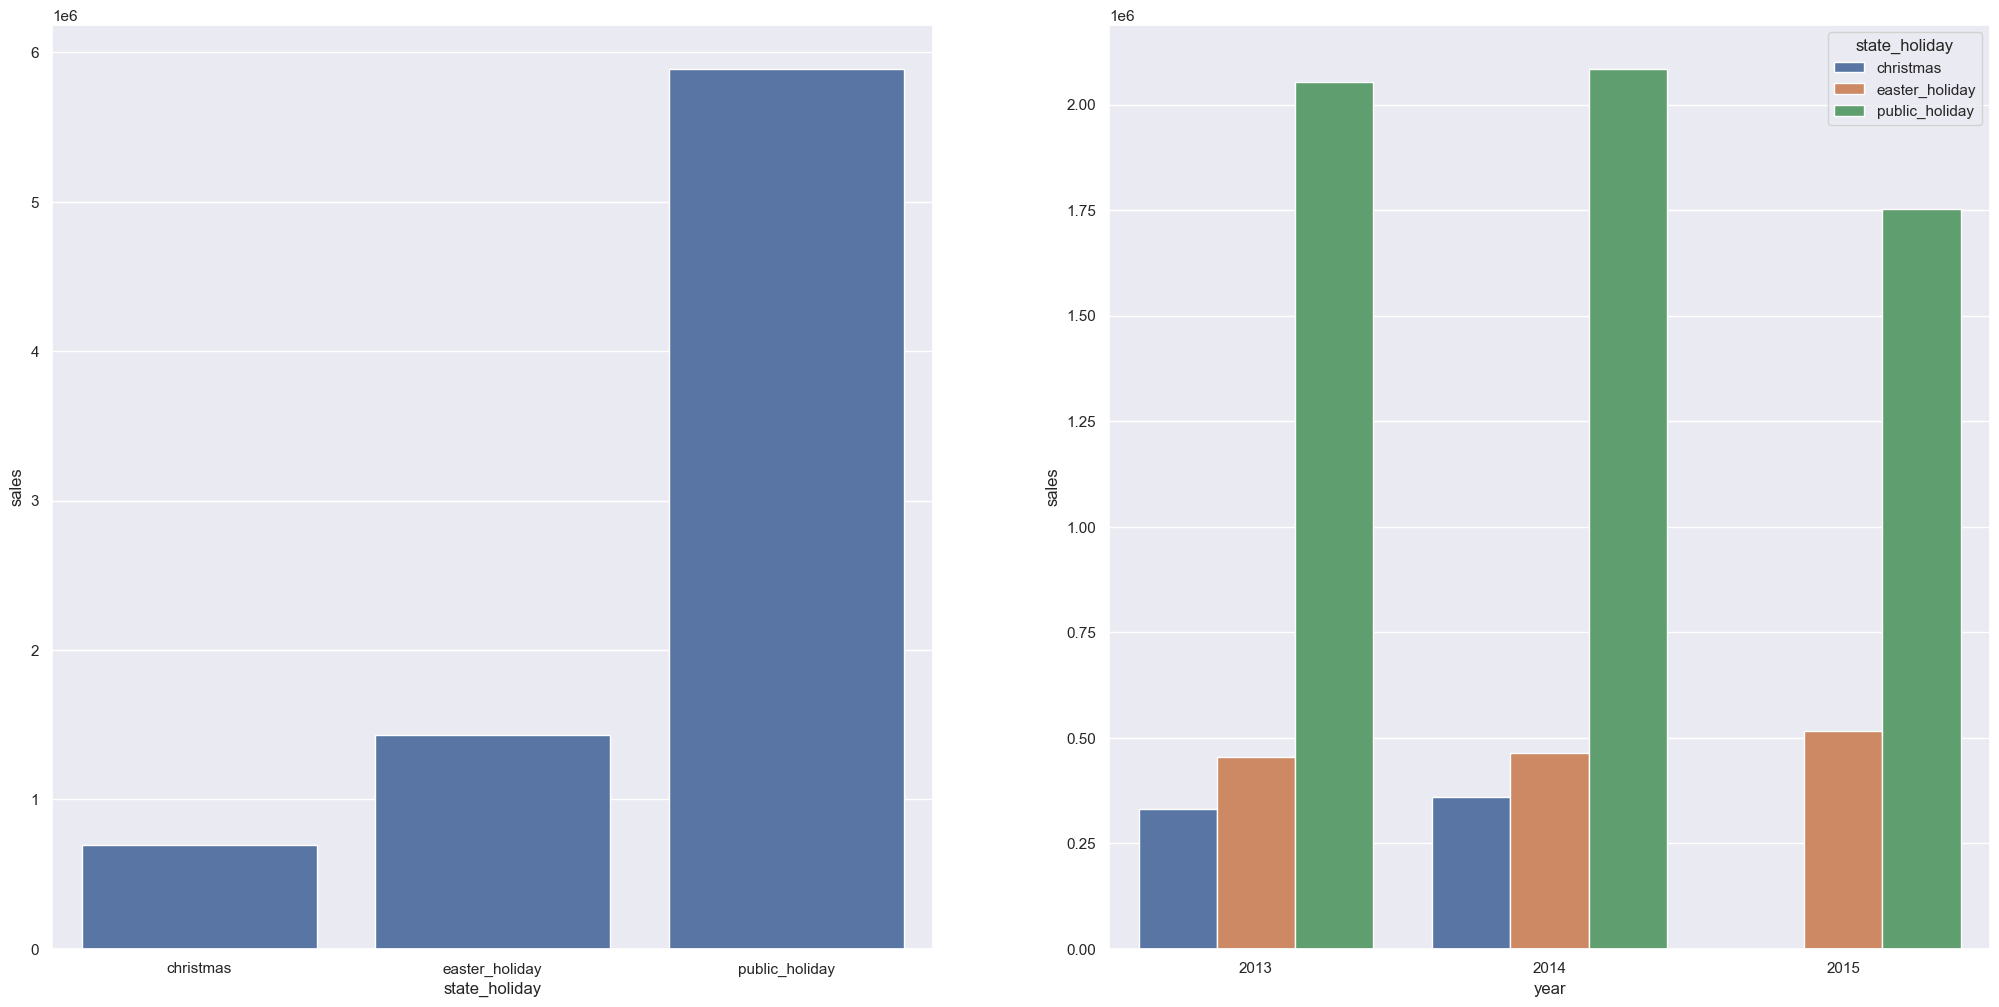

In [140]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

**H8.** Lojas deveriam vender mais ao longo dos anos.
<br>**FALSA** Lojas vendem menos ao longo dos anos.

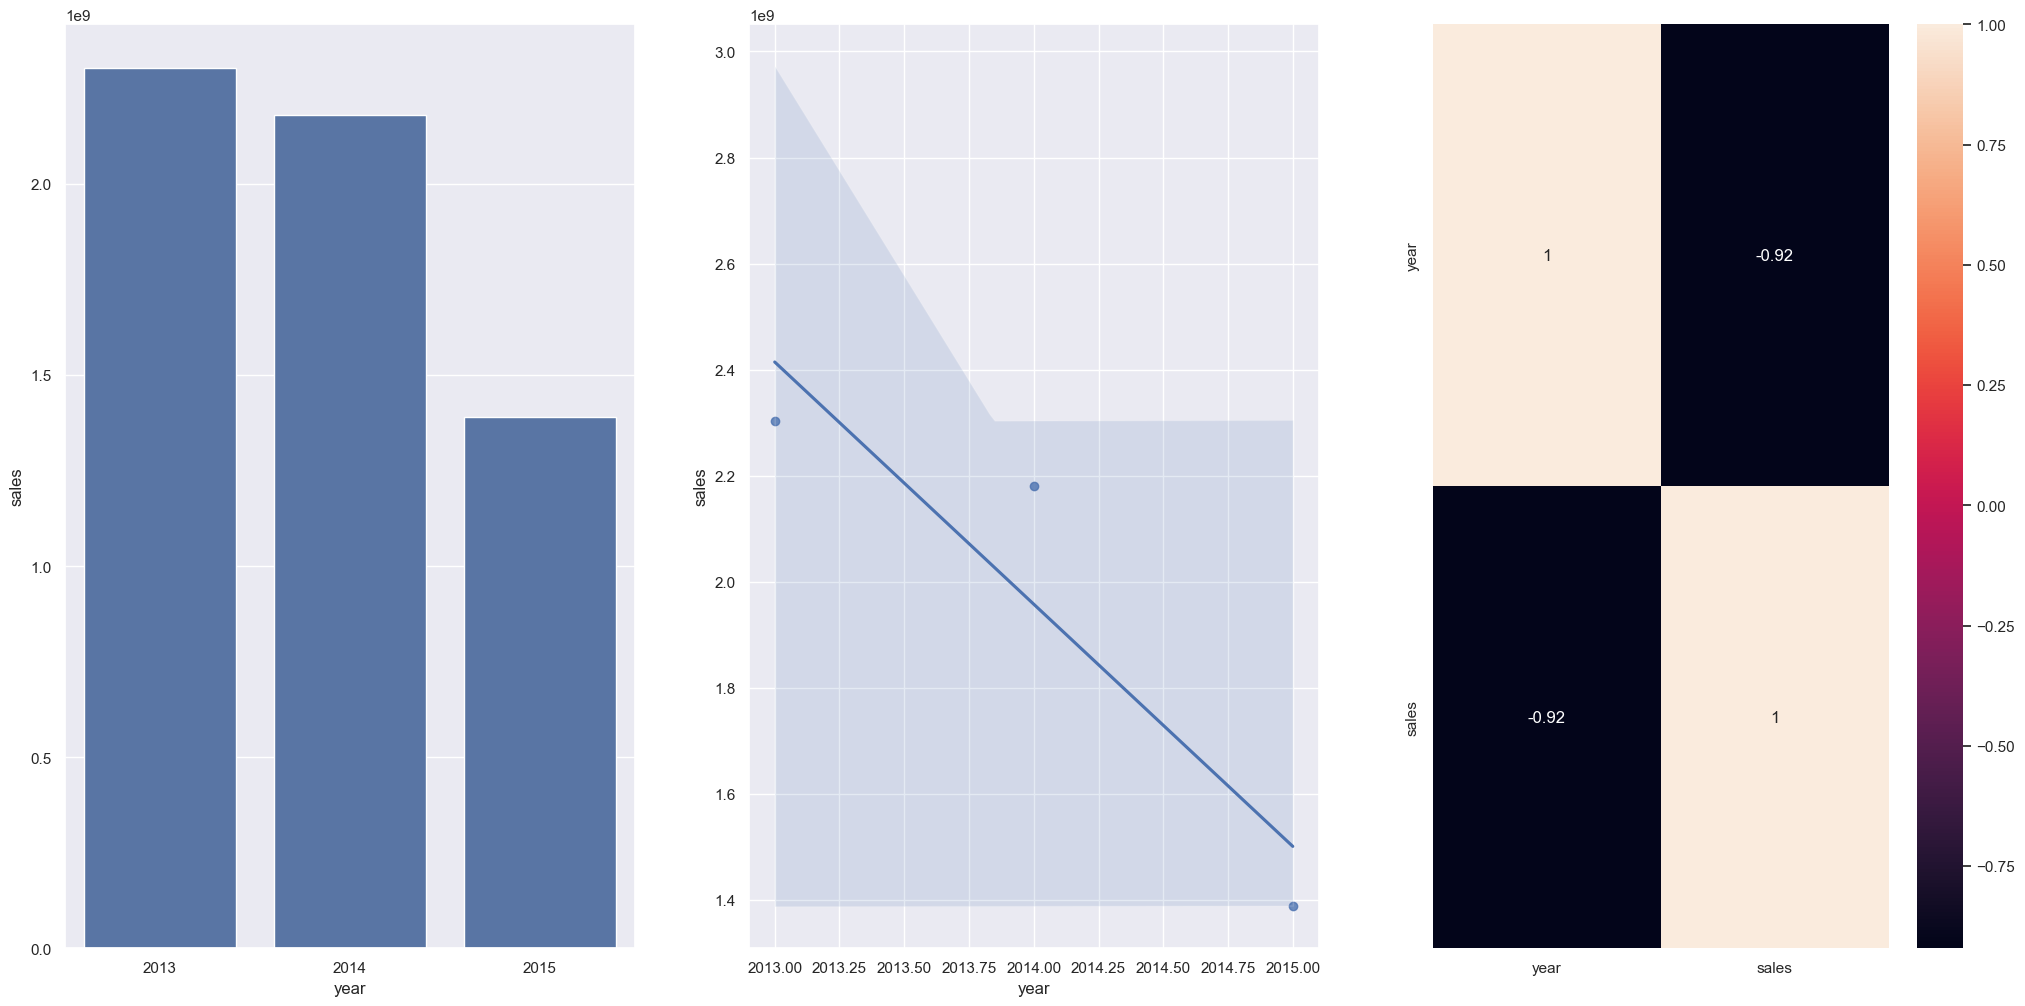

In [141]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

**H9.** Lojas deveriam vender mais no segundo semestre do ano.
<br>**FALSA** Lojas vendem menos no segundo semestre do ano.

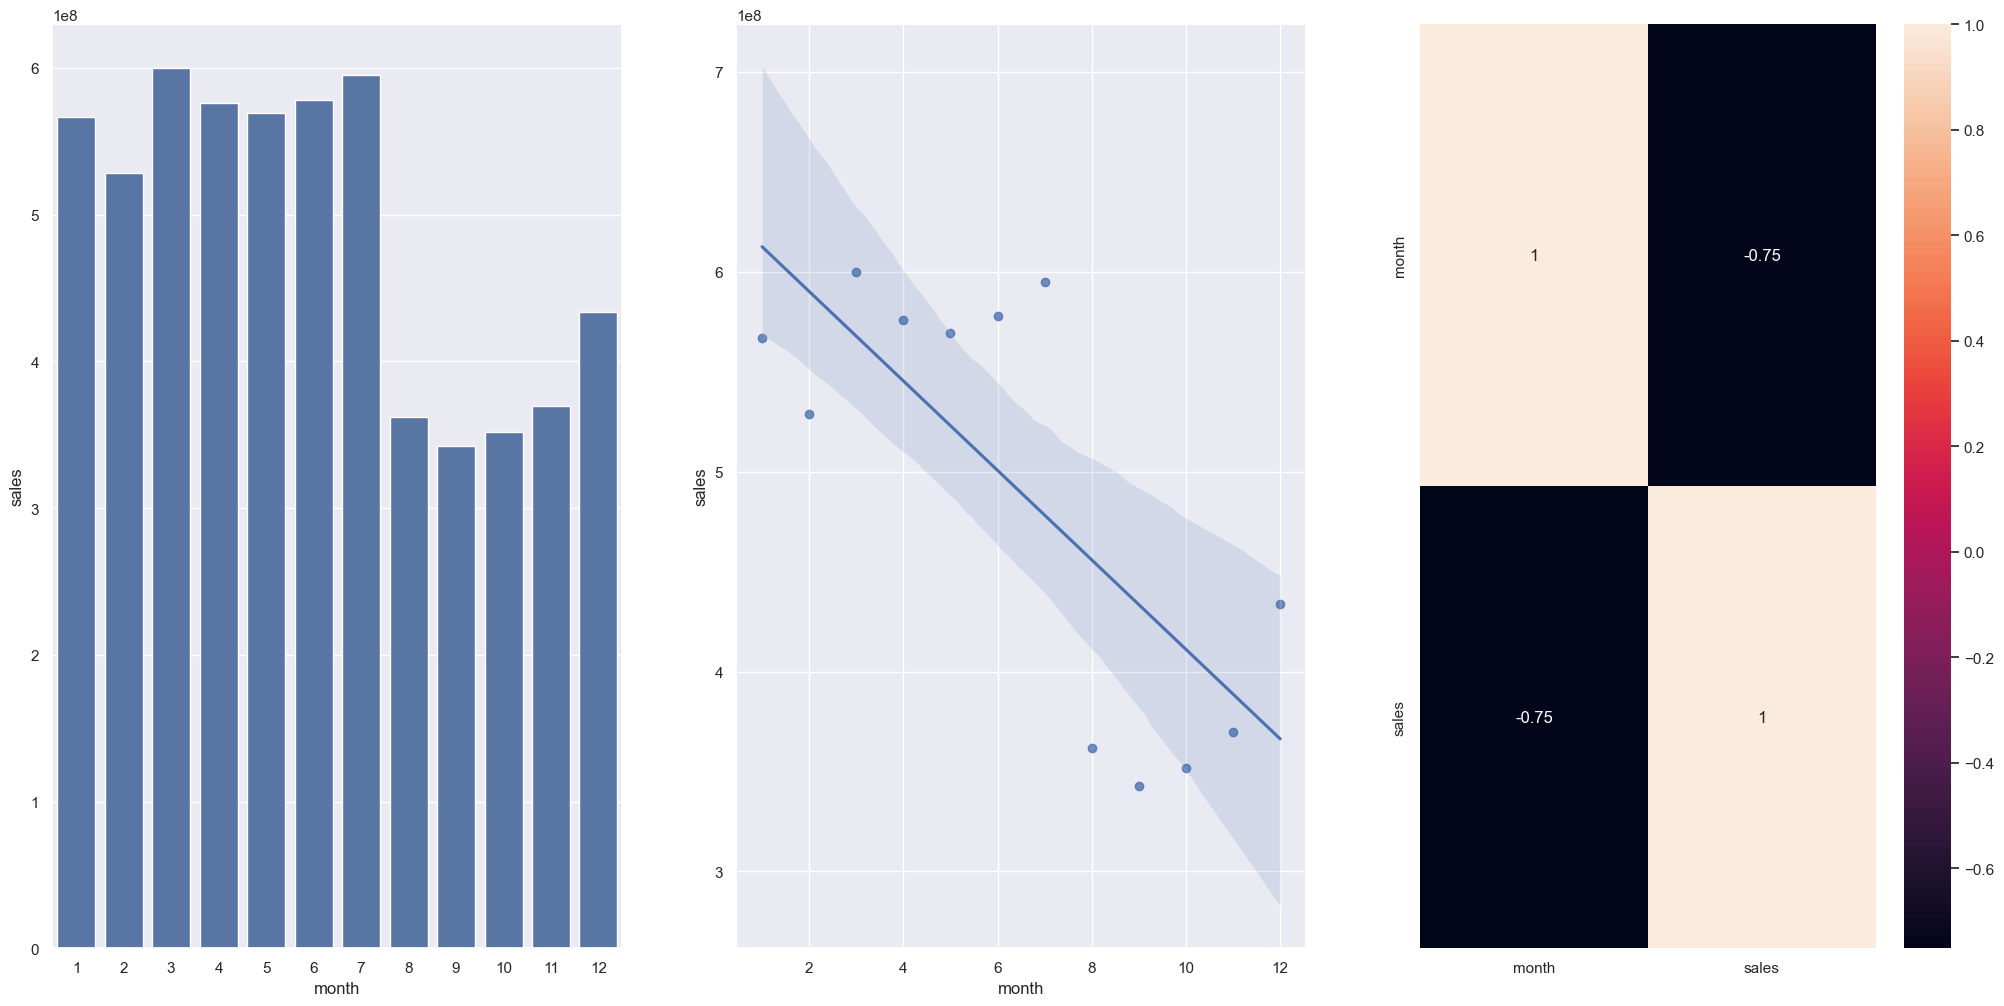

In [142]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

**H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
<br>**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês.

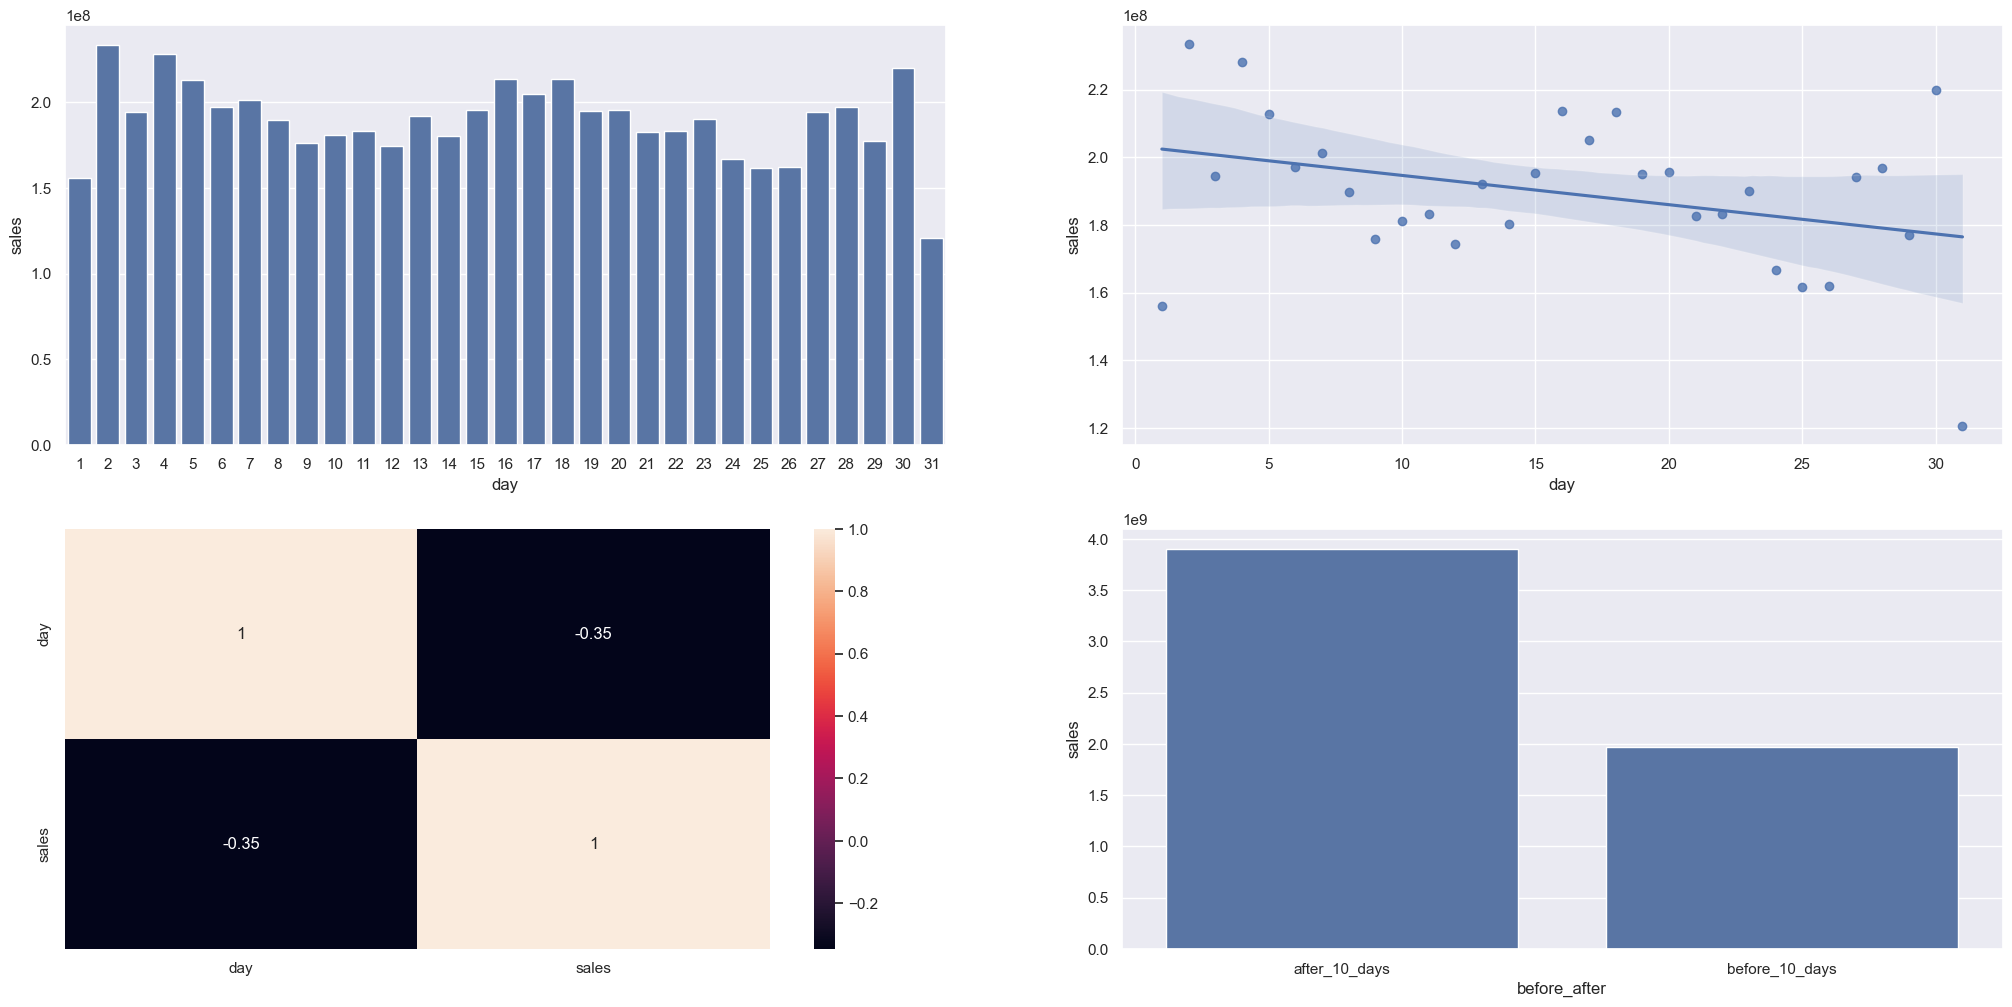

In [143]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

**H11.** Lojas deveriam vender menos aos finais de semana.
<br>**VERDADEIRA** Lojas vendem menos aos finais de semana.

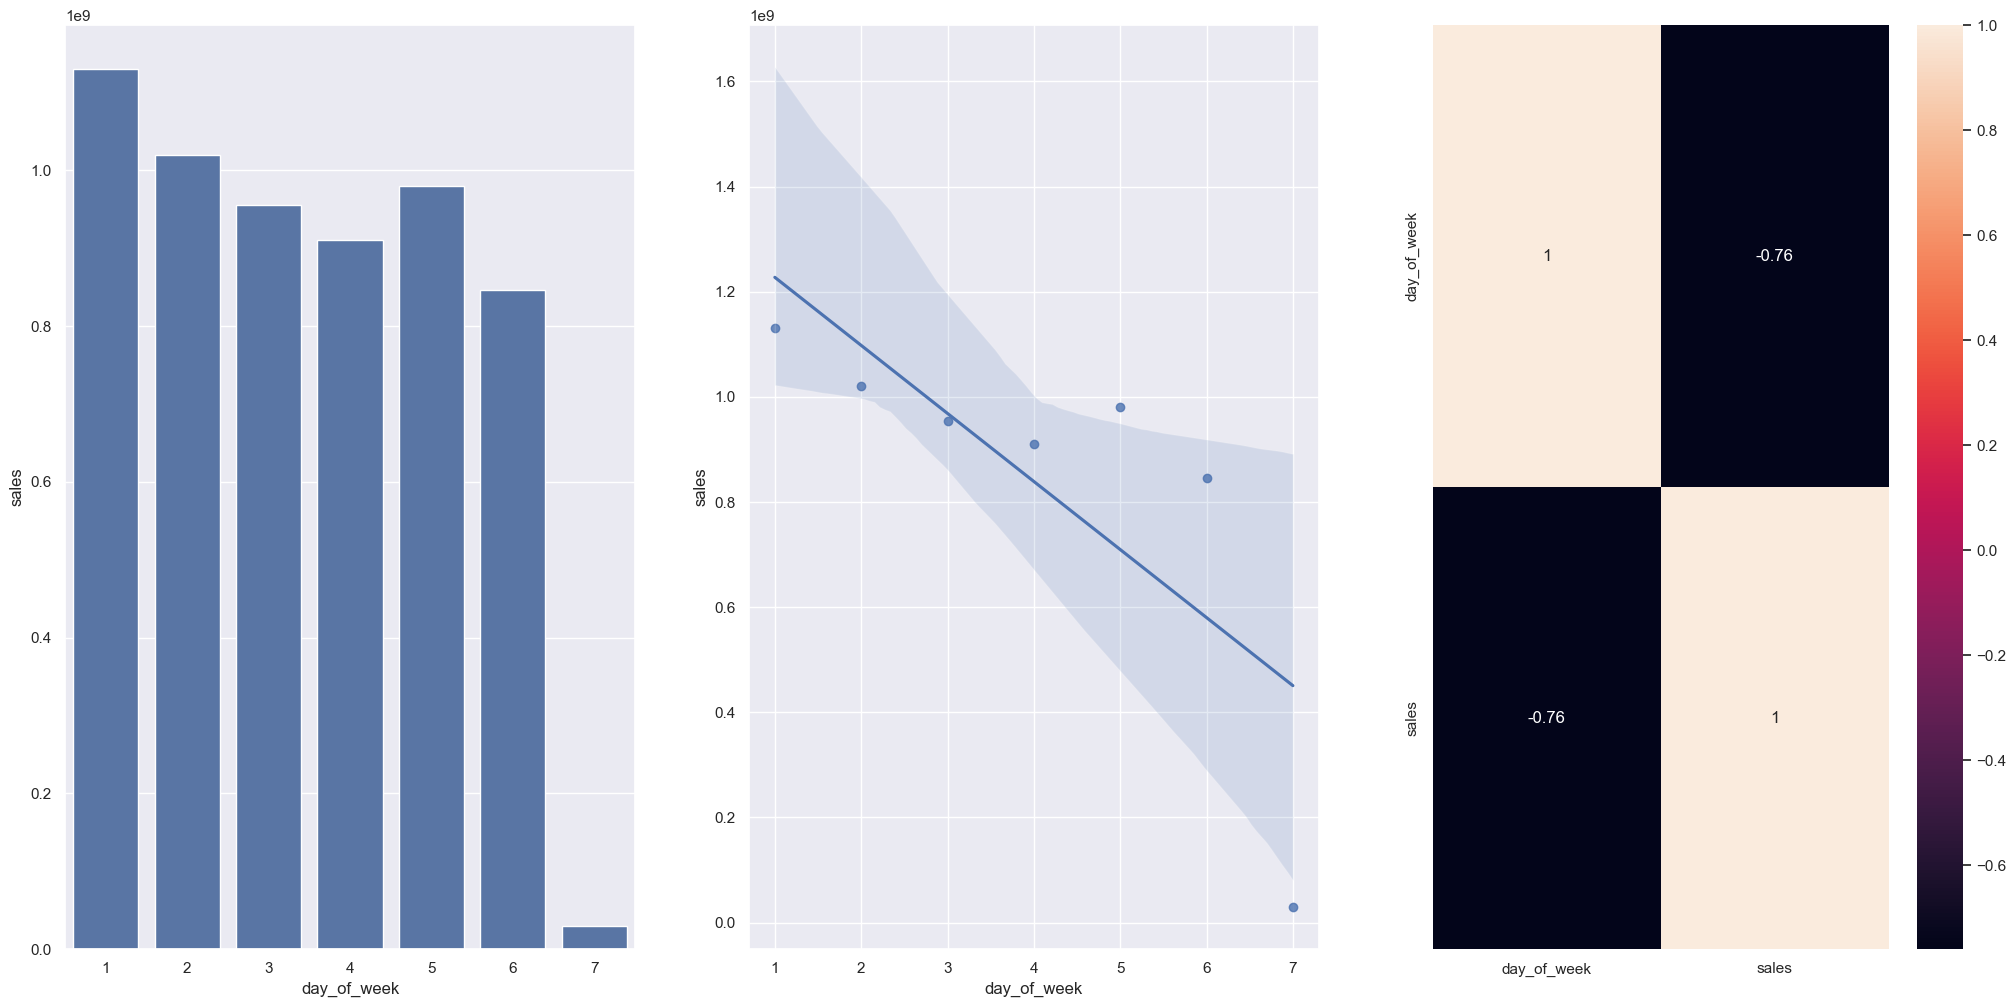

In [144]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

**H12.** Lojas deveriam vender menos durante os feriados escolares.
<br>**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto.

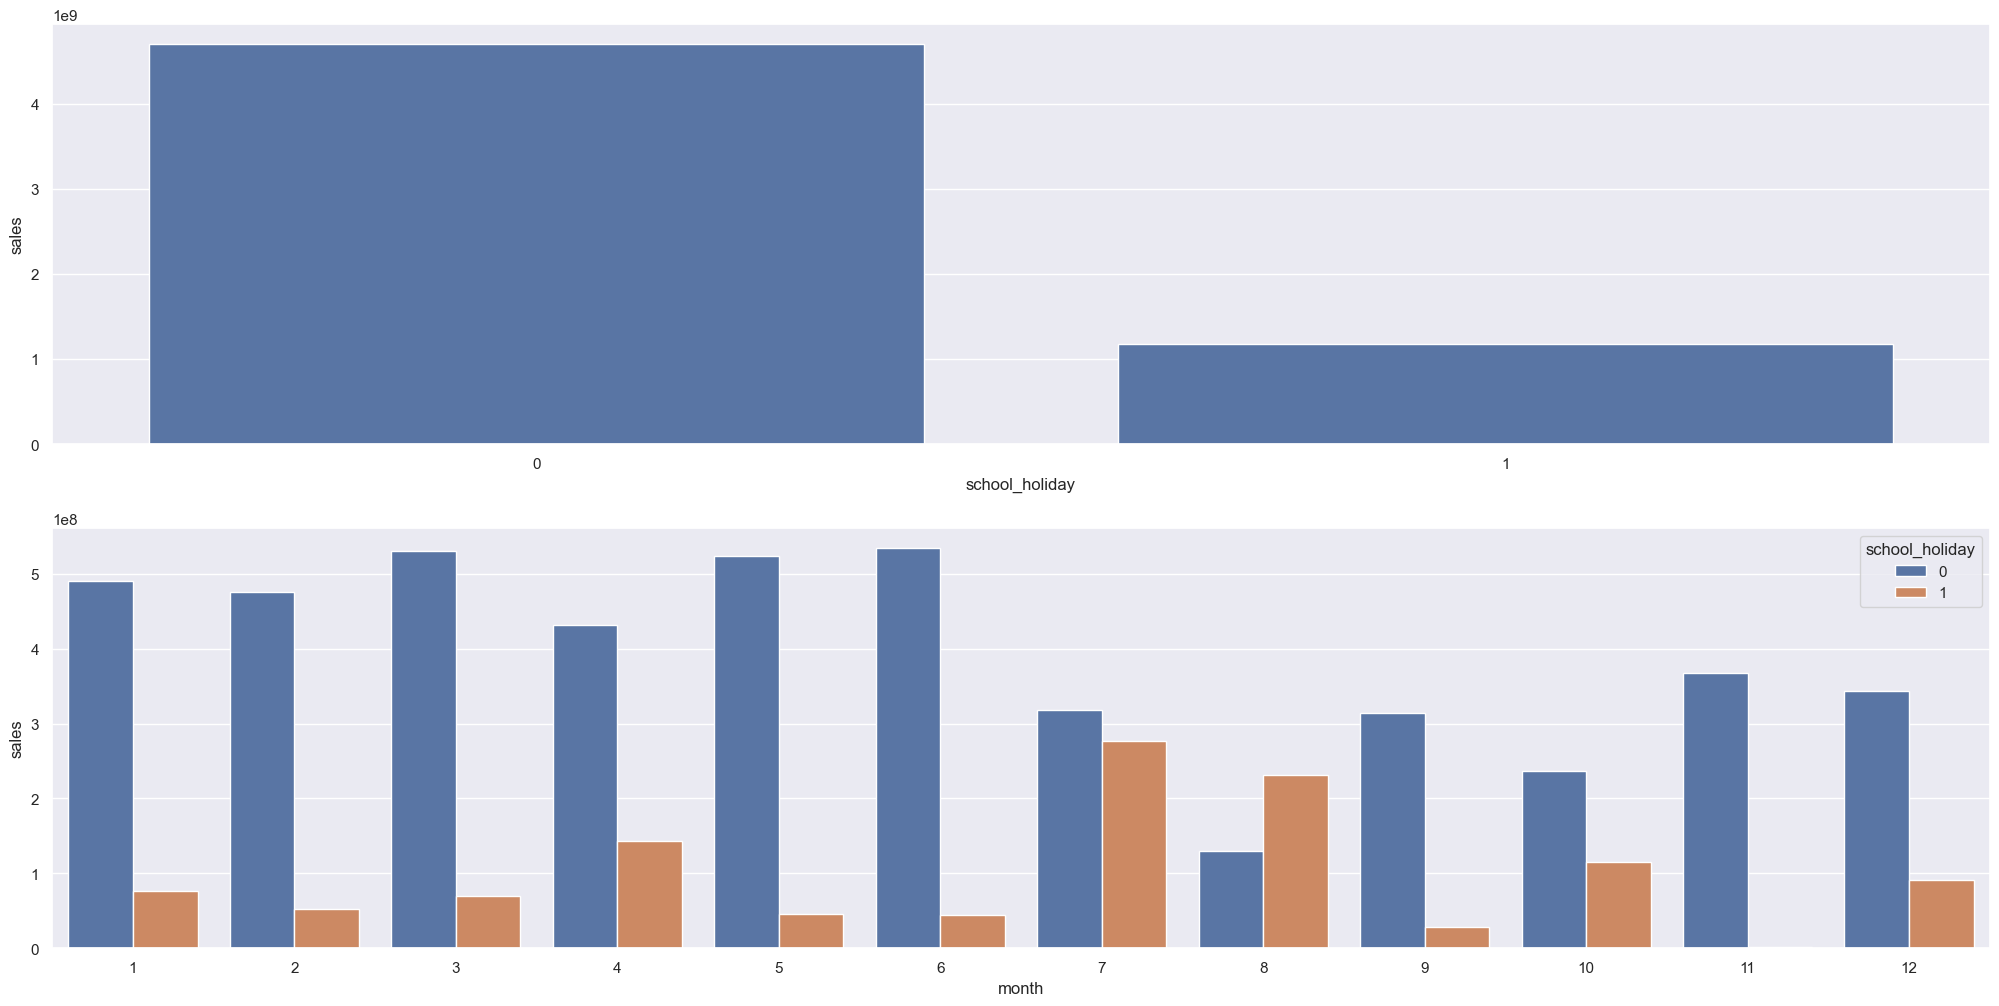

In [145]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1. Resumo das Hipoteses

In [146]:
from tabulate import tabulate

In [147]:
tab=[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
     ]
print(tabulate(tab,headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

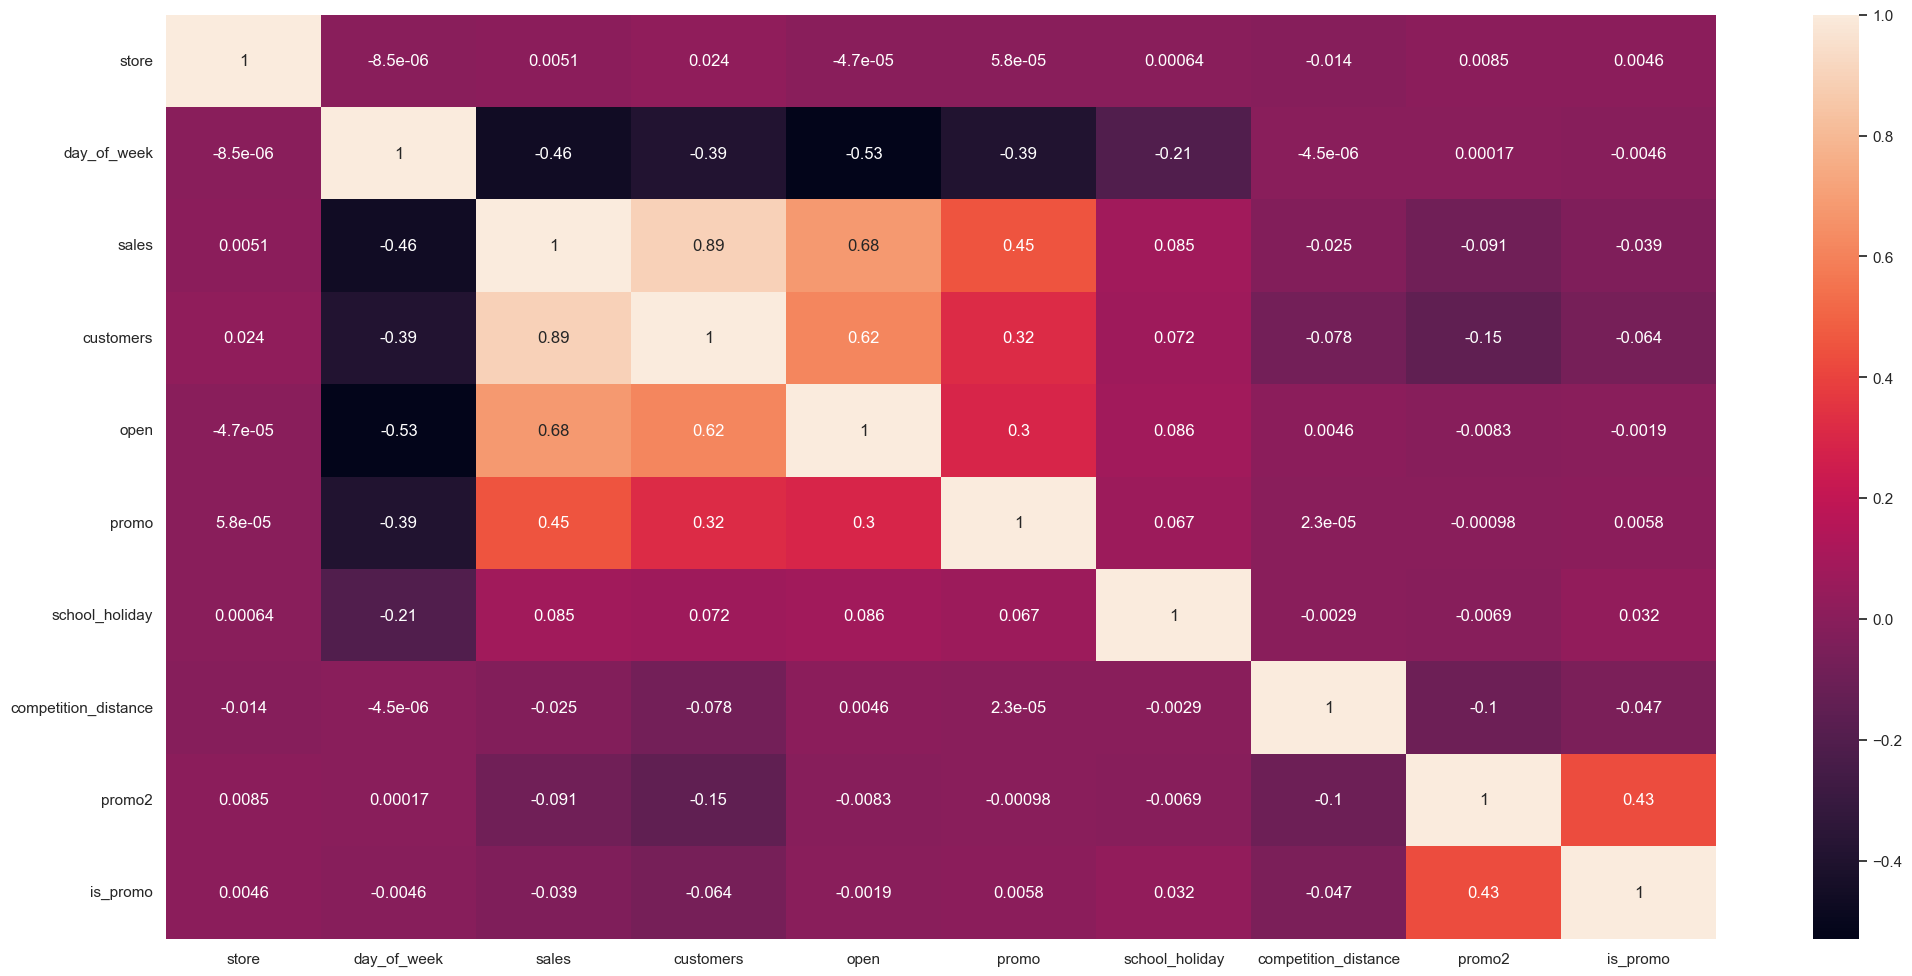

In [148]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

<Axes: >

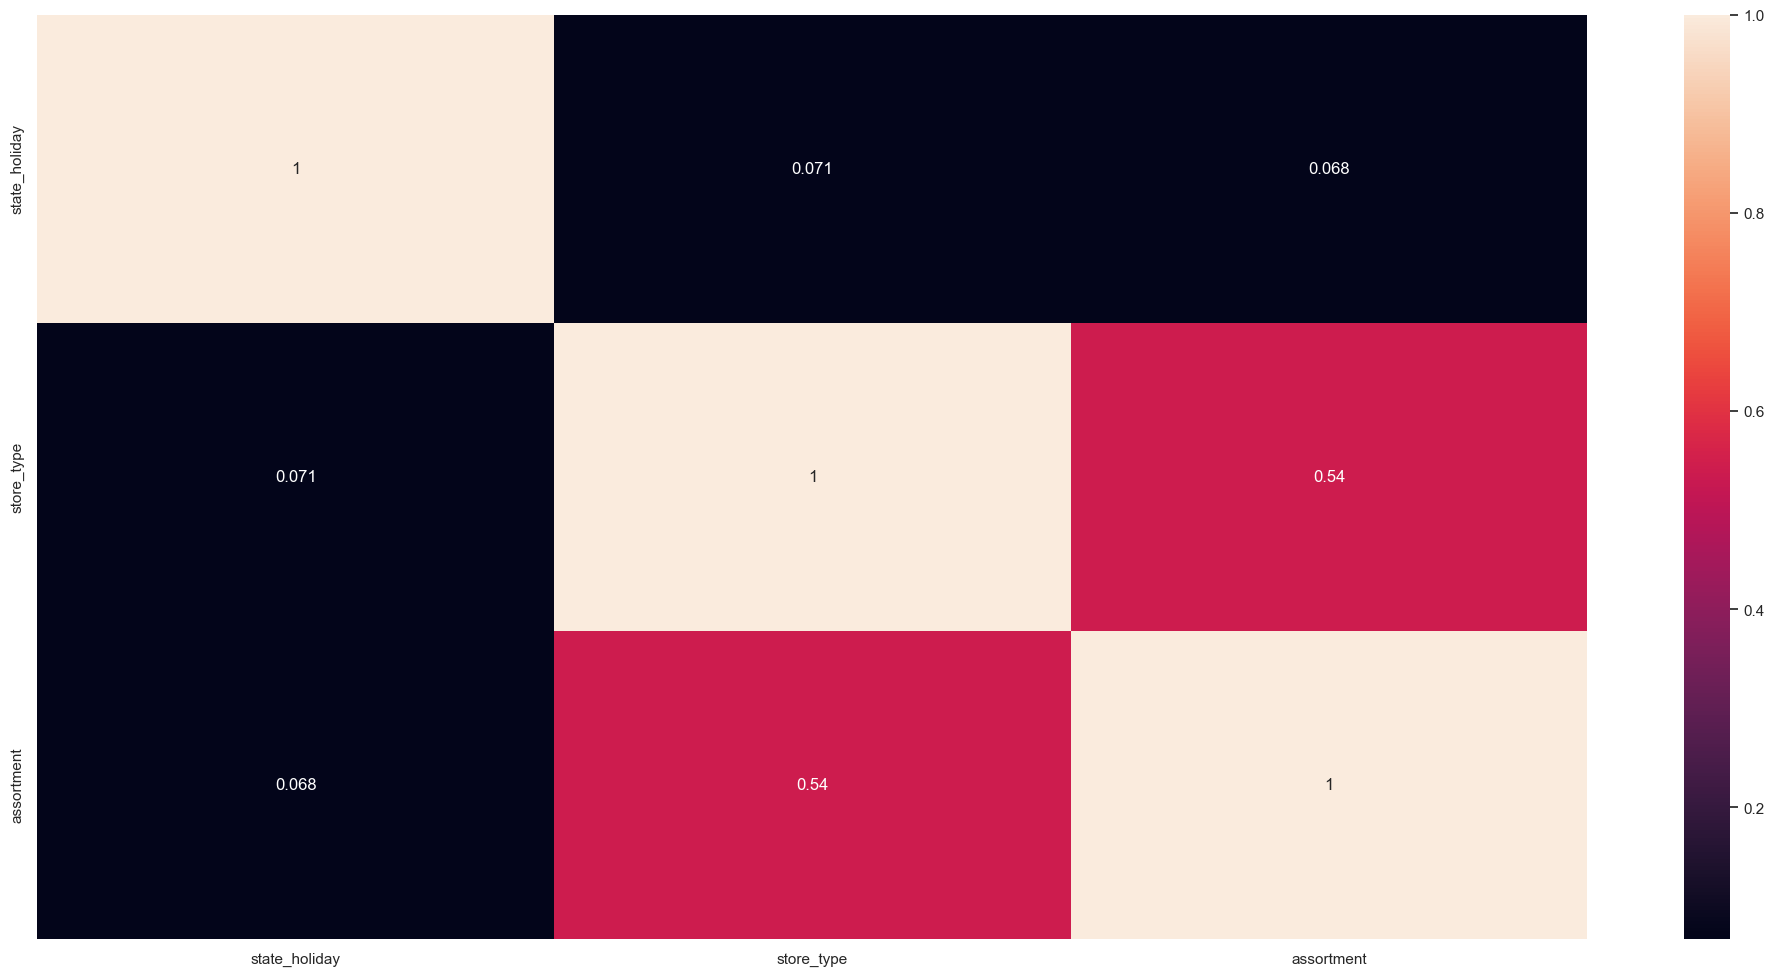

In [149]:
# only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0. PASSO 05 - DATA PREPARATION

In [174]:
df5 = df4.copy()

## 5.1. Normalizacao

No item 4.1.2. Numerical Variable traz alguns gráficosmas não existe nenhuma variável com distribuição normal. 
<br> Nessa caso, não será realizada a normalização.

## 5.2. Rescaling

In [175]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform( df5[['year']].values)

## 5.3. Transformacao

### 5.3.1. Encoding

In [179]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [ ]:
# month
# day
# week of year
# day of week